
# Galaxy vs. quasars

We're now going to classify galaxy vs quasars in the Sloan Digital Sky Survey.

SDSS observed in four bands:
<center>
    <img src="https://github.com/Alice-Palladino/astrostatistics_bicocca_2024/blob/main/working/quasars.png?raw=true" alt="SDSS observations" width="500">
</center>

### Data

The dataset is at solutions/galaxyquasar.csv. I have extracted it myself from the SDSS database using the SQL query reported [here](https://www.astroml.org/_modules/astroML/datasets/sdss_galaxy_colors.html#fetch_sdss_galaxy_colors)

(If you've never used SQL and want to learn something new it's computing, it's very powerful)

### Tasks

- Create arrays for the $(u-g)$, $(g-r)$, $(r-i)$, and $(i-z)$ colors. Also create an array with the class labels where galaxy $=0$ and quasar $=1$.
- Classify the dataset against the target label.
- Try some of the classification methods we've seen so far and evaluate the performance using the ROC curve.
- Remember to split the dataset into training and validation...

### Ideas

- Try using different colors (a subset of them first, than all together). Which is the most important feature?
- What are the colors that better satisfy or invalidate the "Naive" assumption of independence between the attributes?

In [82]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from IPython.display import display, Markdown

from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix

from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis as QDA

from astroML.classification import GMMBayes
from sklearn.model_selection import KFold

from sklearn.neighbors import KNeighborsClassifier

from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier

In [2]:
data = pd.read_csv('galaxyquasar.csv')
data

,u,g,r,i,z,class,z1,zerr
0,18.97213,18.53676,18.58280,18.34936,18.29215,QSO,0.522819,0.000155
1,19.24592,17.47646,16.47817,16.04472,15.68851,GALAXY,0.122846,0.000028
2,19.43536,17.70268,16.91565,16.58327,16.39128,GALAXY,0.000000,0.000000
3,19.31626,18.18312,17.39591,16.94549,16.65395,GALAXY,0.147435,0.000009
4,19.28828,19.11188,18.88937,18.80013,18.49183,QSO,2.011455,0.000631
...,...,...,...,...,...,...,...,...
49995,19.37295,18.12382,17.39886,16.98503,16.70585,GALAXY,0.113016,0.000011
49996,18.52021,16.88262,16.03280,15.56884,15.22454,GALAXY,0.085063,0.000014
49997,18.62718,17.30876,16.87371,16.62399,16.42296,GALAXY,0.054429,0.000008
49998,19.55140,18.27711,17.62101,17.21947,17.03347,GALAXY,0.112571,0.000009


In [3]:
usecols = ['u', 'g', 'r', 'i', 'z', 'class', 'z1', 'zerr']

u_g = np.array(data.get(usecols[0]) - data.get(usecols[1]))
g_r = np.array(data.get(usecols[1]) - data.get(usecols[2]))
r_i = np.array(data.get(usecols[2]) - data.get(usecols[3]))
i_z = np.array(data.get(usecols[3]) - data.get(usecols[4]))

target = np.array(data.get(usecols[5]))
y = np.empty(shape = u_g.size)     # Class labels

for i, label in enumerate(target):
    if (label == 'GALAXY'): y[i] = 0
    elif (label == 'QSO'): y[i] = 1

We can first explore how, for each color, the quasar and galaxy data are distributed:

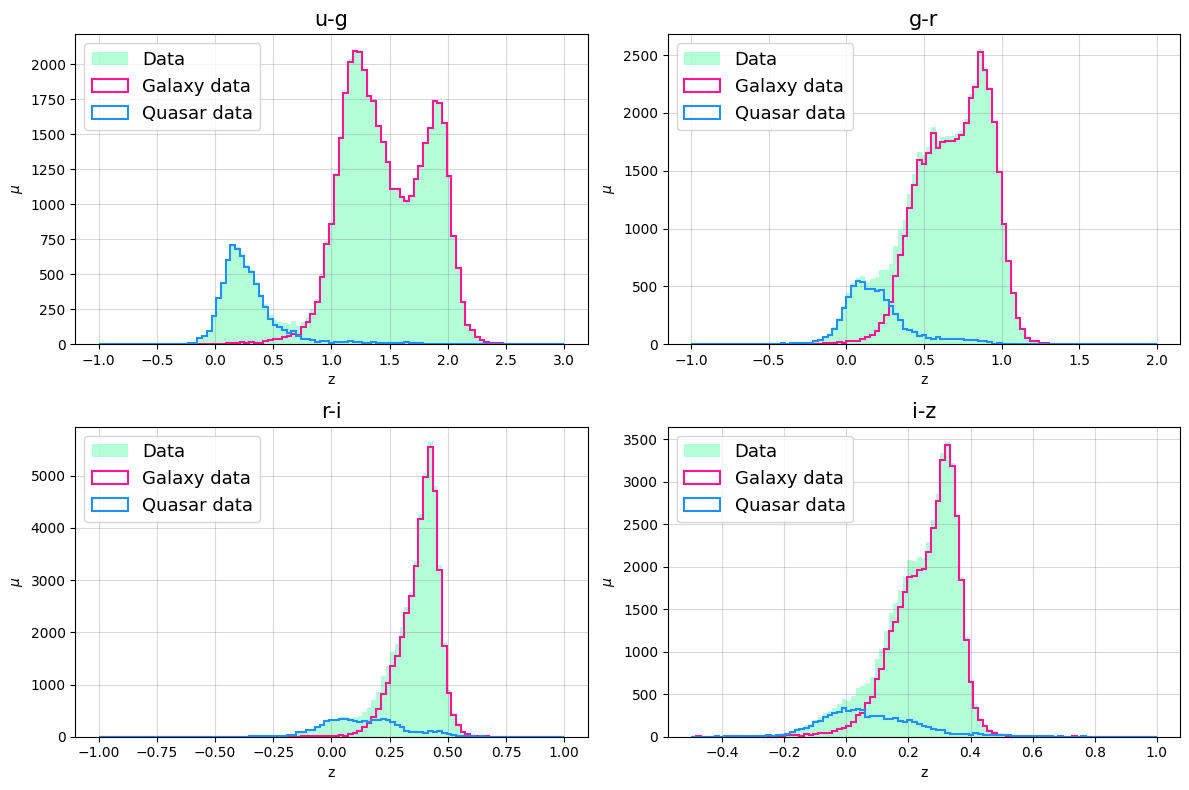

In [4]:
data_array = [u_g, g_r, r_i, i_z]
titles = ['u-g', 'g-r', 'r-i', 'i-z']
bins = [np.linspace(-1, 3, 100), np.linspace(-1, 2, 100), np.linspace(-1, 1, 100), np.linspace(-0.5, 1, 100)]

fig = plt.figure(figsize=(12, 8))
axes = []

for i, col in enumerate(data_array):
    ax = fig.add_subplot(2,2,1+i)
    axes.append(ax)
    plt.hist(col, bins = bins[i], color = 'springgreen', alpha = 0.3, label = 'Data')
    plt.hist(col[y==0], bins = bins[i], histtype = 'step', color = 'deeppink', linewidth = 1.5, alpha = 1, label = 'Galaxy data')
    plt.hist(col[y==1], bins = bins[i], histtype = 'step', color = 'dodgerblue', linewidth = 1.5, alpha = 1, label = 'Quasar data')
    ax.grid(c='grey', alpha = 0.2)
    ax.set_xlabel('z')
    ax.set_ylabel('$\\mu$')
    ax.set_title(titles[i], fontsize = 15)
    ax.grid(alpha=0.3, c='gray')
    ax.legend(loc='upper left', fontsize = 13)

plt.tight_layout()
plt.show()

For the $(u-g)$ data, the distributions are clearly separated; this is not so noticeable for the other colors. 

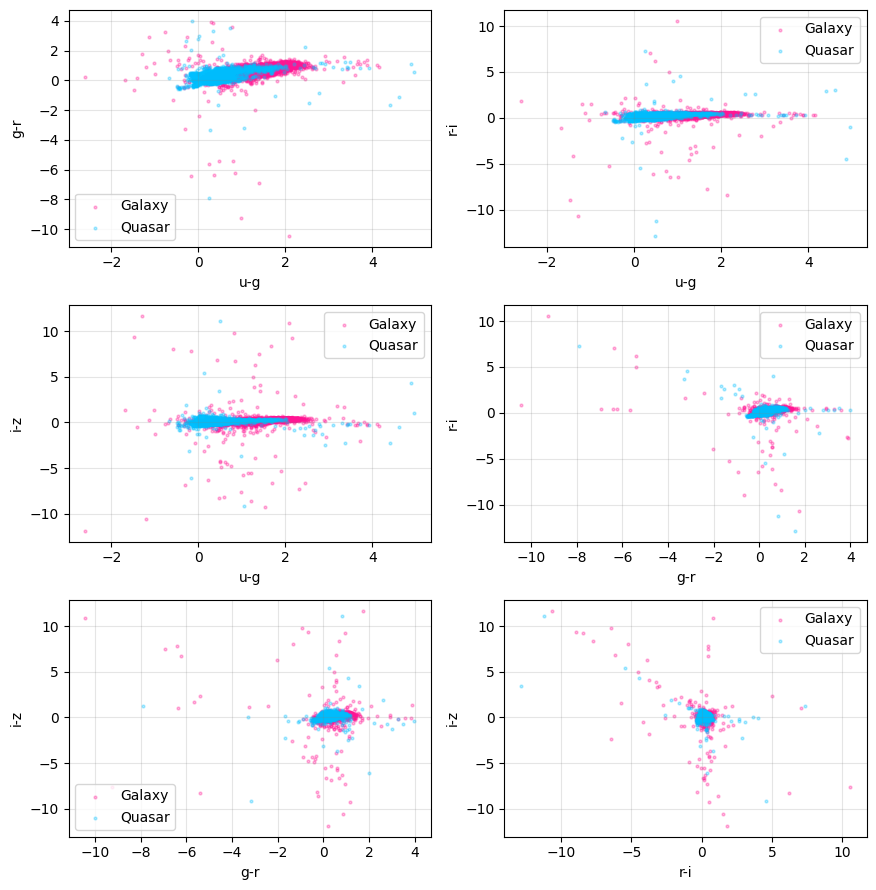

In [5]:
# I could've used corner for the next plots, but the contours were very small and I didn't get a clear idea of the data.

fig, axes = plt.subplots(3, 2, figsize = (9, 9))

axes[0, 0].scatter(u_g[y==0], g_r[y==0], s = 4, c = 'deeppink', alpha = 0.3, label = 'Galaxy')
axes[0, 0].scatter(u_g[y==1], g_r[y==1], s = 4, c = 'deepskyblue', alpha = 0.3, label = 'Quasar')
axes[0, 0].grid(c='grey', alpha = 0.2)
axes[0, 0].set_xlabel('u-g')
axes[0, 0].set_ylabel('g-r')
axes[0, 0].legend()

axes[0, 1].scatter(u_g[y==0], r_i[y==0], s = 4, c = 'deeppink', alpha = 0.3, label = 'Galaxy')
axes[0, 1].scatter(u_g[y==1], r_i[y==1], s = 4, c = 'deepskyblue', alpha = 0.3, label = 'Quasar')
axes[0, 1].grid(c='grey', alpha = 0.2)
axes[0, 1].set_xlabel('u-g')
axes[0, 1].set_ylabel('r-i')
axes[0, 1].legend()


axes[1, 0].scatter(u_g[y==0], i_z[y==0], s = 4, c = 'deeppink', alpha = 0.3, label = 'Galaxy')
axes[1, 0].scatter(u_g[y==1], i_z[y==1], s = 4, c = 'deepskyblue', alpha = 0.3, label = 'Quasar')
axes[1, 0].grid(c='grey', alpha = 0.2)
axes[1, 0].set_xlabel('u-g')
axes[1, 0].set_ylabel('i-z')
axes[1, 0].legend()

axes[1, 1].scatter(g_r[y==0], r_i[y==0], s = 4, c = 'deeppink', alpha = 0.3, label = 'Galaxy')
axes[1, 1].scatter(g_r[y==1], r_i[y==1], s = 4, c = 'deepskyblue', alpha = 0.3, label = 'Quasar')
axes[1, 1].grid(c='grey', alpha = 0.2)
axes[1, 1].set_xlabel('g-r')
axes[1, 1].set_ylabel('r-i')
axes[1, 1].legend()

axes[2, 0].scatter(g_r[y==0], i_z[y==0], s = 4, c = 'deeppink', alpha = 0.3, label = 'Galaxy')
axes[2, 0].scatter(g_r[y==1], i_z[y==1], s = 4, c = 'deepskyblue', alpha = 0.3, label = 'Quasar')
axes[2, 0].grid(c='grey', alpha = 0.2)
axes[2, 0].set_xlabel('g-r')
axes[2, 0].set_ylabel('i-z')
axes[2, 0].legend()

axes[2, 1].scatter(r_i[y==0], i_z[y==0], s = 4, c = 'deeppink', alpha = 0.3, label = 'Galaxy')
axes[2, 1].scatter(r_i[y==1], i_z[y==1], s = 4, c = 'deepskyblue', alpha = 0.3, label = 'Quasar')
axes[2, 1].grid(c='grey', alpha = 0.2)
axes[2, 1].set_xlabel('r-i')
axes[2, 1].set_ylabel('i-z')
axes[2, 1].legend()

plt.tight_layout()
plt.show()

As noticed before, the plots with $(u-g)$ show a bimodality. This suggests that $(u-g)$ could be the most informative feature.


#### Train-test splitting


In [6]:
X=np.array([u_g, g_r, r_i, i_z]).T

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=336)


#### Preliminary work: plotting functions


In [80]:
def single_ROC(X_train, X_test, y_train, y_test, classifier, specify_number):
    
    # Plots the ROC curves for a classifier trained on the single features
    # Specify_number is for the classifiers that require an extra parameter
    
    if (classifier == 'gnb'): clf = GaussianNB()
    elif(classifier == 'qda'): clf = QDA()
    elif (classifier == 'gmmb'): clf = GMMBayes(n_components=specify_number)
    elif (classifier == 'knn'): clf = KNeighborsClassifier(n_neighbors = specify_number)
    elif (classifier == 'rand_for'): clf = RandomForestClassifier(max_depth = specify_number, criterion = 'entropy', random_state = 336, n_jobs = -1)
    elif (classifier == 'boost'): clf = GradientBoostingClassifier(max_depth = specify_number, random_state = 336)
    
    colors = ['u-g', 'g-r', 'r-i', 'i-z']

    print('Training the data with a single feature:\n')

    fig, ax = plt.subplots(1, 2, figsize = (8, 3.5))
    
    for i, col in enumerate(colors):

        clf.fit(X_train[:, i].reshape(-1, 1), y_train)
        y_prob = clf.predict_proba(X_test[:, i].reshape(-1, 1))[:, 1] 
    
        fpr, tpr, thresh = roc_curve(y_test, y_prob)
        ax[0].plot(fpr, tpr, label=col)
        ax[1].plot(fpr, tpr, label=col)

    ax[0].set_xlabel('False positive rate')
    ax[0].set_ylabel('True positive rate')
    ax[0].set_title('ROC curve for ' + classifier + ' - single features')
    ax[0].legend(loc='best')
    ax[0].grid(c='grey', alpha = 0.2)

    ax[1].set_xlabel('False positive rate')
    ax[1].set_ylabel('True positive rate')
    ax[1].set_title('Zoom')
    ax[1].legend(loc='best')
    ax[1].grid(c='grey', alpha = 0.2)
    ax[1].set_ylim(0.7, 1)
    ax[1].set_xlim(0, 0.5)

    plt.tight_layout()
    plt.show()

#-------------------------------------------------------------------------------------------------------------------------------------------------------

def progressive_ROC(X_train, X_test, y_train, y_test, classifier, specify_number):
    
    # Plots the ROC curves for a classifier trained on a increasing number of features.
    
    if (classifier == 'gnb'): clf = GaussianNB()
    elif(classifier == 'qda'): clf = QDA()
    elif (classifier == 'gmmb'): clf = GMMBayes(n_components=specify_number)
    elif (classifier == 'knn'): clf = KNeighborsClassifier(n_neighbors = specify_number)
    elif (classifier == 'rand_for'): clf = RandomForestClassifier(max_depth = specify_number, criterion = 'entropy', random_state = 336, n_jobs = -1)
    elif (classifier == 'boost'): clf = GradientBoostingClassifier(max_depth = specify_number, random_state = 336)
    
    colors = ['u-g', 'g-r', 'r-i', 'i-z']

    print('Training the data with multiple features:\n')

    fig, ax = plt.subplots(1, 2, figsize = (8, 3.5))
    
    for i in range(4):

        clf.fit(X_train[:, 0:i+1], y_train)
        y_prob = clf.predict_proba(X_test[:, 0:i+1])[:, 1] 
    
        fpr, tpr, thresh = roc_curve(y_test, y_prob)
        ax[0].plot(fpr, tpr, label= '%i features' % (i+1))
        ax[1].plot(fpr, tpr, label= '%i features' % (i+1))

    ax[0].set_xlabel('False positive rate')
    ax[0].set_ylabel('True positive rate')
    ax[0].set_title('ROC curve for ' + classifier + ' - multiple features')
    ax[0].legend(loc='best')
    ax[0].grid(c='grey', alpha = 0.2)

    ax[1].set_xlabel('False positive rate')
    ax[1].set_ylabel('True positive rate')
    ax[1].set_title('Zoom')
    ax[1].legend(loc='best')
    ax[1].grid(c='grey', alpha = 0.2)
    ax[1].set_ylim(0.9, 1)
    ax[1].set_xlim(0, 0.5)

    plt.tight_layout()
    plt.show()

#-------------------------------------------------------------------------------------------------------------------------------------------------------

def plot_classified_hists(X_train, X_test, y_train, y_test, y_train_pred, y_test_pred, color):

    # Plots the histograms for the classified data of a given color (u-g, g-r, r-i, i-z)
    # Plots:
    # - The predicted labels for the train dataset;
    # - The true labels for the train dataset;
    # - The predicted labels for the test dataset;
    # - The true labels for the test dataset.
    
    # Defining color
    if (color == 'u-g'): ind = 0
    elif (color == 'g-r'): ind = 1
    elif (color == 'r-i'): ind = 2
    elif (color == 'i-z'): ind = 3

    bins_vec = [np.linspace(-1, 3, 100), np.linspace(-1, 2, 100), np.linspace(-1, 1, 100), np.linspace(-0.5, 1, 100)]
    bins = bins_vec[ind]
    
    fig, axes = plt.subplots(2, 2, figsize = (10, 7))
    
    axes[0, 0].hist(X_train[:, ind], bins = bins, color = 'springgreen', alpha = 0.3, label = 'Train data')
    axes[0, 0].hist(X_train[y_train_pred==0, ind], bins = bins, histtype = 'step', color = 'deeppink', linewidth = 1.5, alpha = 1, label = 'Galaxy data')
    axes[0, 0].hist(X_train[y_train_pred==1, ind], bins = bins, histtype = 'step', color = 'dodgerblue', linewidth = 1.5, alpha = 1, label = 'Quasar data')
    axes[0, 0].grid(c='grey', alpha = 0.2)
    axes[0, 0].set_xlabel(color)
    axes[0, 0].set_title('Predicted labels for train dataset')
    axes[0, 0].legend()
    
    axes[0, 1].hist(X_train[:, ind], bins = bins, color = 'springgreen', alpha = 0.3, label = 'Train data')
    axes[0, 1].hist(X_train[y_train==0, ind], bins = bins, histtype = 'step', color = 'deeppink', linewidth = 1.5, alpha = 1, label = 'Galaxy data')
    axes[0, 1].hist(X_train[y_train==1, ind], bins = bins, histtype = 'step', color = 'dodgerblue', linewidth = 1.5, alpha = 1, label = 'Quasar data')
    axes[0, 1].grid(c='grey', alpha = 0.2)
    axes[0, 1].set_xlabel(color)
    axes[0, 1].set_title('True labels for train dataset')
    axes[0, 1].legend()

    axes[1, 0].hist(X_test[:, ind], bins = bins, color = 'springgreen', alpha = 0.3, label = 'Test data')
    axes[1, 0].hist(X_test[y_test_pred==0, ind], bins = bins, histtype = 'step', color = 'deeppink', linewidth = 1.5, alpha = 1, label = 'Galaxy data')
    axes[1, 0].hist(X_test[y_test_pred==1, ind], bins = bins, histtype = 'step', color = 'dodgerblue', linewidth = 1.5, alpha = 1, label = 'Quasar data')
    axes[1, 0].grid(c='grey', alpha = 0.2)
    axes[1, 0].set_xlabel(color)
    axes[1, 0].set_title('Predicted labels for test dataset')
    axes[1, 0].legend()
    
    axes[1, 1].hist(X_test[:, ind], bins = bins, color = 'springgreen', alpha = 0.3, label = 'Test data')
    axes[1, 1].hist(X_test[y_test==0, ind], bins = bins, histtype = 'step', color = 'deeppink', linewidth = 1.5, alpha = 1, label = 'Galaxy data')
    axes[1, 1].hist(X_test[y_test==1, ind], bins = bins, histtype = 'step', color = 'dodgerblue', linewidth = 1.5, alpha = 1, label = 'Quasar data')
    axes[1, 1].grid(c='grey', alpha = 0.2)
    axes[1, 1].set_xlabel(color)
    axes[1, 1].set_title('True labels for test dataset')
    axes[1, 1].legend()

    plt.tight_layout()
    plt.show()

#-------------------------------------------------------------------------------------------------------------------------------------------------------

def mislabeled_points(X_train, X_test, y_train, y_test, y_train_pred, y_test_pred, color1, color2):

    # Plots, in a color1 vs color2 plane, the mislabeled points for the train and test data.
    
    # Defining color1
    if (color1 == 'u-g'): ind1 = 0
    elif (color1 == 'g-r'): ind1 = 1
    elif (color1 == 'r-i'): ind1 = 2
    elif (color1 == 'i-z'): ind1 = 3

    # Defining color2
    if (color2 == 'u-g'): ind2 = 0
    elif (color2 == 'g-r'): ind2 = 1
    elif (color2 == 'r-i'): ind2 = 2
    elif (color2 == 'i-z'): ind2 = 3
    
    # "False quasar" = fq: galaxies mislabeled as quasars
    # "False galaxy" = fg: quasars mislabeled as galaxies
    
    mislabels_train = np.where(y_train != y_train_pred)[0]
    fq_train_indexes = mislabels_train[(y_train[mislabels_train] == 0) & (y_train_pred[mislabels_train] == 1)]
    fg_train_indexes = mislabels_train[(y_train[mislabels_train] == 1) & (y_train_pred[mislabels_train] == 0)]
    fq_train = X_train[fq_train_indexes]
    fg_train = X_train[fg_train_indexes]

    mislabels_test = np.where(y_test != y_test_pred)[0]
    fq_test_indexes = mislabels_test[(y_test[mislabels_test] == 0) & (y_test_pred[mislabels_test] == 1)]
    fg_test_indexes = mislabels_test[(y_test[mislabels_test] == 1) & (y_test_pred[mislabels_test] == 0)]
    fq_test = X_test[fq_test_indexes]
    fg_test = X_test[fg_test_indexes]

    
    fig, ax = plt.subplots(1, 2, figsize = (10, 4))
    
    ax[0].scatter(X_train[:, ind1], X_train[:, ind2], s = 4, c = 'grey', alpha = 0.3, label = 'Data')
    ax[0].scatter(fq_train[:, ind1], fq_train[:, ind2], s = 4, c = 'gold', alpha = 0.7, label = '"False quasars"')
    ax[0].scatter(fg_train[:, ind1], fg_train[:, ind2], s = 4, c = 'magenta', alpha = 0.7, label = '"False galaxies"')
    ax[0].grid(c='grey', alpha = 0.2)
    ax[0].set_title('Mislabeled train datapoints')
    ax[0].set_xlabel(color1)
    ax[0].set_ylabel(color2)
    ax[0].legend()
    
    ax[1].scatter(X_test[:, ind1], X_test[:, ind2], s = 4, c = 'grey', alpha = 0.3, label = 'Data')
    ax[1].scatter(fq_test[:, ind1], fq_test[:, ind2], s = 4, c = 'gold', alpha = 0.7, label = '"False quasars"')
    ax[1].scatter(fg_test[:, ind1], fg_test[:, ind2], s = 4, c = 'magenta', alpha = 0.7, label = '"False galaxies"')
    ax[1].grid(c='grey', alpha = 0.2)
    ax[1].set_title('Mislabeled test datapoints')
    ax[1].set_xlabel(color1)
    ax[1].set_ylabel(color2)
    ax[1].legend()
    
    plt.tight_layout()
    plt.show()

#-------------------------------------------------------------------------------------------------------------------------------------------------------

def table_results(y, y_pred): 

    accuracy = accuracy_score(y, y_pred)
    contamination = 1 - precision_score(y, y_pred)
    completeness = recall_score(y, y_pred)
    tn, fp, fn, tp = confusion_matrix(y, y_pred).ravel()

    return accuracy, contamination, completeness, tn, fp, fn, tp


## Naive Bayes

We can start the classification with a Naive Bayes classificator. First, we can train the classificator on the single features and see, plotting the ROC curves, what is the most informative one.

Training the data with a single feature:



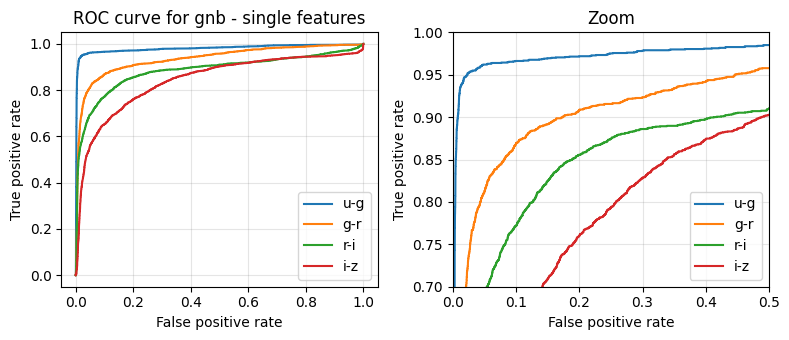

In [8]:
single_ROC(X_train, X_test, y_train, y_test, 'gnb', _)

So, as suspected, the most informative feature is the $(u-g)$ one. Let's plot the ROC curves for the classificator trained on different numbers of features:

Training the data with multiple features:



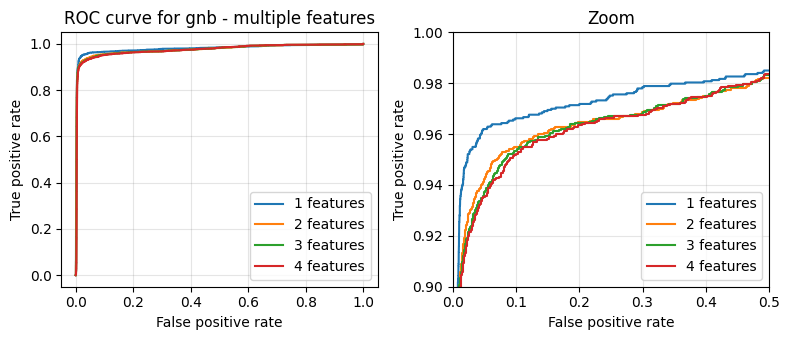

In [9]:
progressive_ROC(X_train, X_test, y_train, y_test, 'gnb', _)

This plot tells us that just the $(u-g)$ feature is enough to classify the dataset. Let's see the results for a classifier trained only on this feature vs one trained on all features:

In [10]:
gnb_results_train = []
gnb_results_test = []

# First, the one trained on a single feature:
gnb = GaussianNB()
gnb.fit(X_train[:, 0].reshape(-1, 1), y_train)

y_train_pred_gnb_single = gnb.predict(X_train[:, 0].reshape(-1, 1))
y_test_pred_gnb_single = gnb.predict(X_test[:, 0].reshape(-1, 1))

gnb_results_train.append(table_results(y_train, y_train_pred_gnb_single))
gnb_results_test.append(table_results(y_test, y_test_pred_gnb_single))

# Then, the one trained on all the features:
gnb = GaussianNB()
gnb.fit(X_train, y_train)

y_train_pred_gnb_tot = gnb.predict(X_train)
y_test_pred_gnb_tot = gnb.predict(X_test)

gnb_results_train.append(table_results(y_train, y_train_pred_gnb_tot))
gnb_results_test.append(table_results(y_test, y_test_pred_gnb_tot))

In [11]:
clf_names = ['GNB', 'GNB']
clf_notes = ['(u-g)', 'All features']

gnb_results_train_df = pd.DataFrame(gnb_results_train, columns = ['Accuracy', 'Contamination', 'Completeness', 'True negatives', 'False positives', 'False negatives', 'True positives'])
gnb_results_train_df[['Accuracy', 'Contamination', 'Completeness']] = gnb_results_train_df[['Accuracy', 'Contamination', 'Completeness']].round(3)
gnb_results_train_df.insert(0, 'Classifier', clf_names)
gnb_results_train_df.insert(1, 'Notes', clf_notes)

gnb_results_test_df = pd.DataFrame(gnb_results_test, columns = ['Accuracy', 'Contamination', 'Completeness', 'True negatives', 'False positives', 'False negatives', 'True positives'])
gnb_results_test_df[['Accuracy', 'Contamination', 'Completeness']] = gnb_results_test_df[['Accuracy', 'Contamination', 'Completeness']].round(3)
gnb_results_test_df.insert(0, 'Classifier', clf_names)
gnb_results_test_df.insert(1, 'Notes', clf_notes)

In [12]:
display(Markdown('### GNB - Train results:'))
display(gnb_results_train_df)

display(Markdown('### GNB - Test results:'))
display(gnb_results_test_df)

### GNB - Train results:

,Classifier,Notes,Accuracy,Contamination,Completeness,True negatives,False positives,False negatives,True positives
0,GNB,(u-g),0.981,0.062,0.929,29688,309,353,4650
1,GNB,All features,0.973,0.113,0.926,29409,588,369,4634


### GNB - Test results:

,Classifier,Notes,Accuracy,Contamination,Completeness,True negatives,False positives,False negatives,True positives
0,GNB,(u-g),0.981,0.062,0.925,12738,131,160,1971
1,GNB,All features,0.970,0.117,0.913,12611,258,185,1946


As predicted by the ROC curves, the classifier trained only on the $(u-g)$ performs better. 
Let's visualize the results for it in an histogram first (so, only for the $(u-g)$ feature), and then in a scatter plot (where we'll plot the second most informative feature, $(g-r)$, on the y-axis). The following graphs show:

- The predicted labels for the train dataset;
- The true labels for the train dataset;
- The predicted labels for the test dataset;
- The true labels for the test dataset.

#### Results for GNB classifier trained on the $(u-g)$ feature

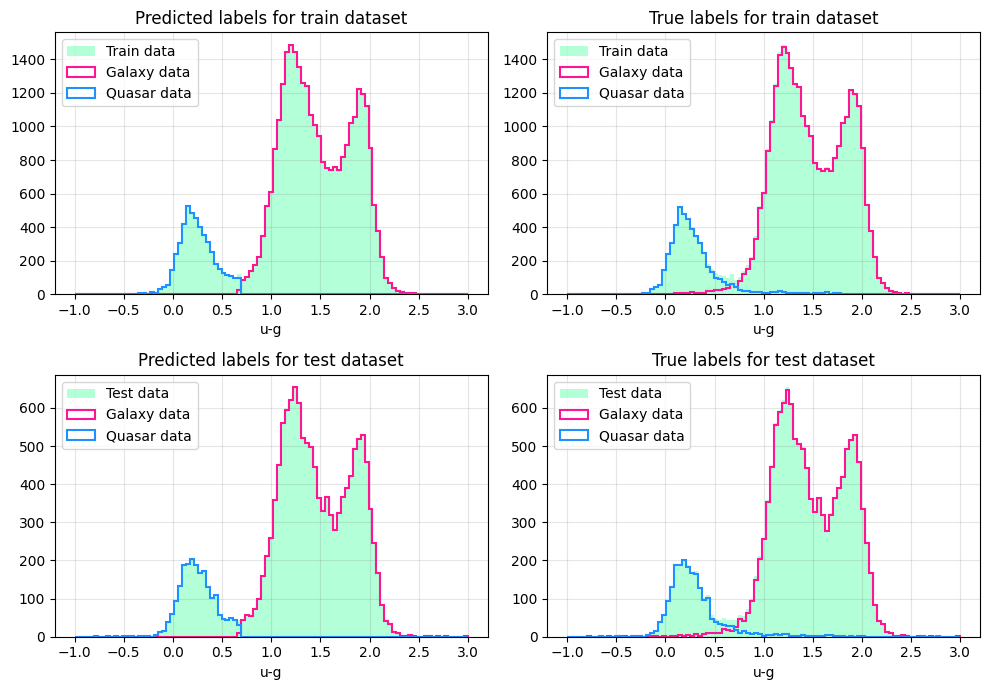

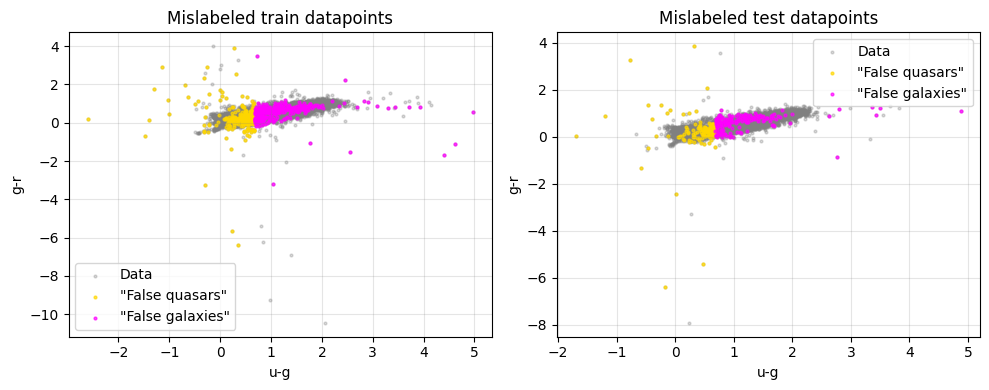

In [13]:
display(Markdown('#### Results for GNB classifier trained on the $(u-g)$ feature'))

plot_classified_hists(X_train, X_test, y_train, y_test, y_train_pred_gnb_single, y_test_pred_gnb_single, 'u-g')

mislabeled_points(X_train, X_test, y_train, y_test, y_train_pred_gnb_single, y_test_pred_gnb_single, 'u-g', 'g-r')

The mismatched points are no surprise: training in only one feature, it's like we drew a vertical line splitting the two distributions, so the tails have been mislabeled.

In [14]:
# For the dataframe in the summary, later: keeping only the single feature line

gnb_results_train_df = gnb_results_train_df.drop(index = 1)
gnb_results_test_df = gnb_results_test_df.drop(index = 1)


## Quadratic Discriminant Analysis

Let's try now using a QDA classification. As before, we'll first plot the ROC curves:

Training the data with a single feature:



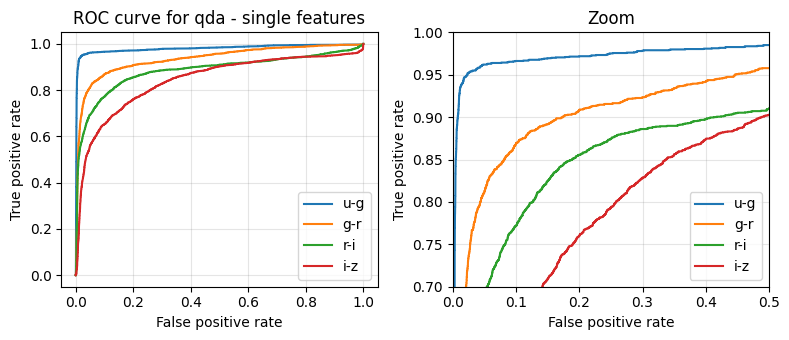

Training the data with multiple features:



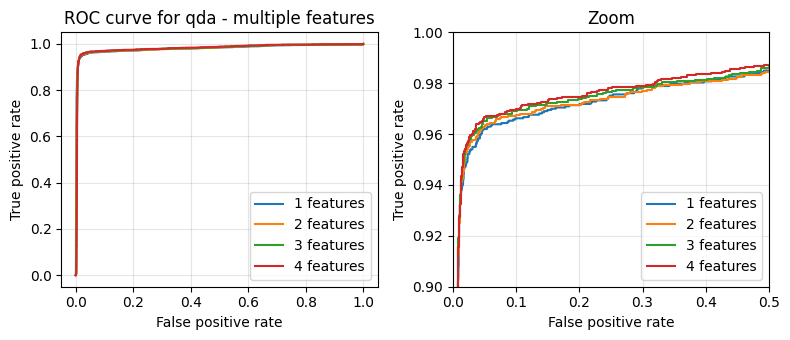

In [15]:
single_ROC(X_train, X_test, y_train, y_test, 'qda', _)
progressive_ROC(X_train, X_test, y_train, y_test, 'qda', _)

The first plots look identical to the ones seen for the Naive Bayes classifier, while the ROC curves for the classifier trained on all the features are different. 

First: does this classifier, trained on a single feature, really yield the same results as the GNB one?

In [16]:
for i in range(4):
    qda = QDA()
    qda.fit(X_train[:, i].reshape(-1, 1), y_train)
    
    y_train_pred_qda = qda.predict(X_train[:, i].reshape(-1, 1))
    y_test_pred_qda = qda.predict(X_test[:, i].reshape(-1, 1))

    gnb = GaussianNB()
    gnb.fit(X_train[:, i].reshape(-1, 1), y_train)
    
    y_train_pred_gnb = gnb.predict(X_train[:, i].reshape(-1, 1))
    y_test_pred_gnb = gnb.predict(X_test[:, i].reshape(-1, 1))
    
    print('%i° feature:' % (i+1))
    
    print('   Train: ' + str(np.array_equal(y_train_pred_qda, y_train_pred_gnb))) 
    
    if np.array_equal(y_train_pred_qda, y_train_pred_gnb) == False:
        print('\tNumber of different predictions: %i' % np.sum(y_train_pred_qda != y_train_pred_gnb))
        
    print('   Test: '+ str(np.array_equal(y_test_pred_qda, y_test_pred_gnb)))

    if np.array_equal(y_test_pred_qda, y_test_pred_gnb) == False:
        print('\tNumber of different predictions: %i' % np.sum(y_test_pred_qda != y_test_pred_gnb))
        
    print()

1° feature:
   Train: True
   Test: True

2° feature:
   Train: False
	Number of different predictions: 1
   Test: True

3° feature:
   Train: True
   Test: True

4° feature:
   Train: True
   Test: True



So, training a GNB and a QDA on a single feature _almost_ yields the same result.

We're searching now for the best QDA classifier. Given the ROC curves, we can cross-validate on the number of features to train the model on.

In [17]:
n_splits = 100

accuracy_cv_array = np.empty(4)
precision_cv_array = np.empty(4)
completeness_cv_array = np.empty(4)
auc_roc_cv_array = np.empty(4)

kf = KFold(n_splits=n_splits, shuffle=True, random_state=336)

for i in range(4):
    
    qda = QDA()
    
    accuracy = []
    precision = []
    completeness = []
    auc_roc = []
    
    for train_index, test_index in kf.split(X_train):
        X_train_cv, X_test_cv = X_train[train_index], X_train[test_index]
        y_train_cv, y_test_cv = y_train[train_index], y_train[test_index]

        # Leaving X_test and y_test for the final evaluation
        
        qda.fit(X_train_cv[:, 0:i+1], y_train_cv)
        y_pred_test_cv = qda.predict(X_test_cv[:, 0:i+1])
        y_prob_test_cv = qda.predict_proba(X_test_cv[:, 0:i+1])[:, 1] 
        
        accuracy.append(accuracy_score(y_test_cv, y_pred_test_cv))
        precision.append(precision_score(y_test_cv, y_pred_test_cv))
        completeness.append(recall_score(y_test_cv, y_pred_test_cv))

        fpr, tpr, _ = roc_curve(y_test_cv, y_prob_test_cv)
        auc_roc.append(auc(fpr, tpr))

    accuracy_cv_array[i] = np.mean(accuracy)
    precision_cv_array[i] = np.mean(precision)
    completeness_cv_array[i] = np.mean(completeness)
    auc_roc_cv_array[i] = np.mean(auc_roc)

In [18]:
df_cv_qda = pd.DataFrame({
    'Number of features': range(1, 5),
    'Accuracy': accuracy_cv_array,
    'AUC-ROC': auc_roc_cv_array,
    'Precision': precision_cv_array,
    'Completeness': completeness_cv_array
})

df_cv_qda[['AUC-ROC', 'Accuracy', 'Precision', 'Completeness']] = df_cv_qda[['AUC-ROC', 'Accuracy', 'Precision', 'Completeness']].round(4)

display(df_cv_qda)

,Number of features,Accuracy,AUC-ROC,Precision,Completeness
0,1,0.9811,0.9803,0.9375,0.9289
1,2,0.9813,0.9807,0.9368,0.9316
2,3,0.9814,0.9803,0.9364,0.9329
3,4,0.9805,0.9805,0.9327,0.9308


Since precision and completeness are almost the same in each case, we can simply use the accuracy as a scoring metric. This means that the best QDA classifier is the one trained on the first three features - although the results are almost identical, and maybe a different choice in the cross-validation would have given us a different best classifier.

_Note: a higher accuracy doesn't automatically imply a higher AUC-ROC. Until now, we've selected the best classifier based on its AUC-ROC only because the differences between the ROC curves were evident (and the accuracies reflected these choices). From now on, we'll use accuracies as a scoring metric, but we'll still get a first idea with the ROC curves._

In [19]:
qda_results_train = []
qda_results_test = []
# It's gonna be a single line, but it's easier for the dataframe later

qda = QDA()
qda.fit(X_train[:, 0:3], y_train)

y_train_pred_qda_best = qda.predict(X_train[:, 0:3])
y_test_pred_qda_best = qda.predict(X_test[:, 0:3])

qda_results_train.append(table_results(y_train, y_train_pred_qda_best))
qda_results_test.append(table_results(y_test, y_test_pred_qda_best))

In [20]:
clf_names = ['QDA']
clf_notes = ['3 features']

qda_results_train_df = pd.DataFrame(qda_results_train, columns = ['Accuracy', 'Contamination', 'Completeness', 'True negatives', 'False positives', 'False negatives', 'True positives'])
qda_results_train_df[['Accuracy', 'Contamination', 'Completeness']] = qda_results_train_df[['Accuracy', 'Contamination', 'Completeness']].round(3)
qda_results_train_df.insert(0, 'Classifier', clf_names)
qda_results_train_df.insert(1, 'Notes', clf_notes)

qda_results_test_df = pd.DataFrame(qda_results_test, columns = ['Accuracy', 'Contamination', 'Completeness', 'True negatives', 'False positives', 'False negatives', 'True positives'])
qda_results_test_df[['Accuracy', 'Contamination', 'Completeness']] = qda_results_test_df[['Accuracy', 'Contamination', 'Completeness']].round(3)
qda_results_test_df.insert(0, 'Classifier', clf_names)
qda_results_test_df.insert(1, 'Notes', clf_notes)

In [21]:
display(Markdown('### QDA - Train results:'))
display(qda_results_train_df)

display(Markdown('### QDA - Test results:'))
display(qda_results_test_df)

### QDA - Train results:

,Classifier,Notes,Accuracy,Contamination,Completeness,True negatives,False positives,False negatives,True positives
0,QDA,3 features,0.981,0.064,0.934,29679,318,332,4671


### QDA - Test results:

,Classifier,Notes,Accuracy,Contamination,Completeness,True negatives,False positives,False negatives,True positives
0,QDA,3 features,0.98,0.068,0.929,12725,144,152,1979


These results are very similar to the GNB ones. Let's plot the distributions:

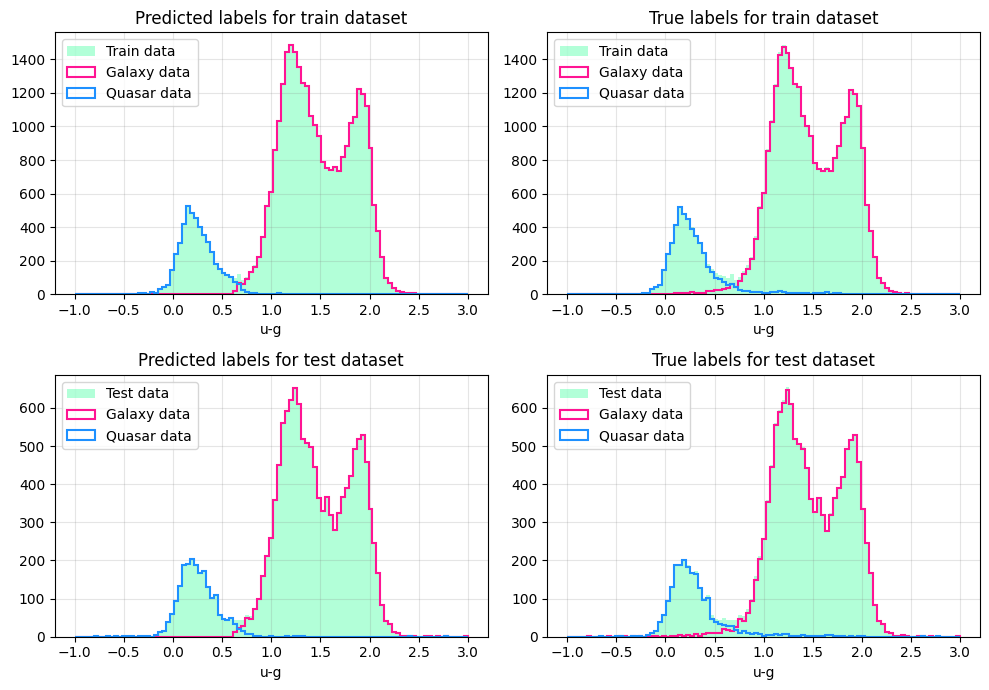

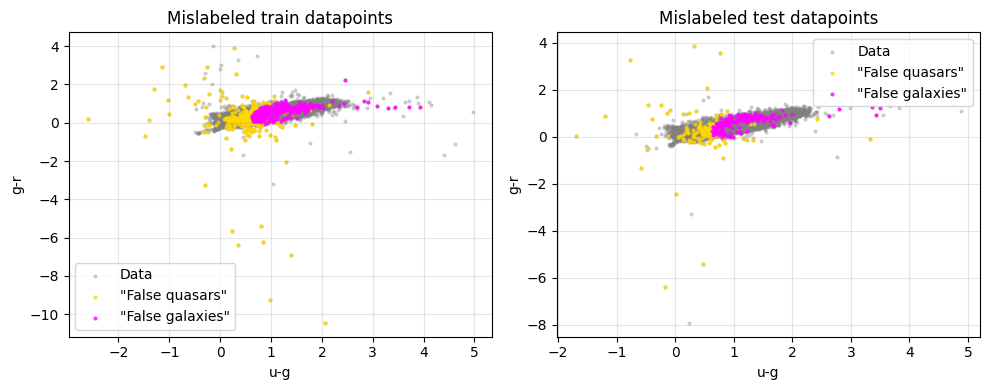

In [22]:
plot_classified_hists(X_train, X_test, y_train, y_test, y_train_pred_qda_best, y_test_pred_qda_best, 'u-g')
mislabeled_points(X_train, X_test, y_train, y_test, y_train_pred_qda_best, y_test_pred_qda_best, 'u-g', 'g-r')


## GMM Bayes Classifier

With this classifier, we have to decide what are the best number of components and the best number of features to train the classifier on. As a start, we can see how the performance varies for the different features, keeping n_components fixed:

Training the data with a single feature:



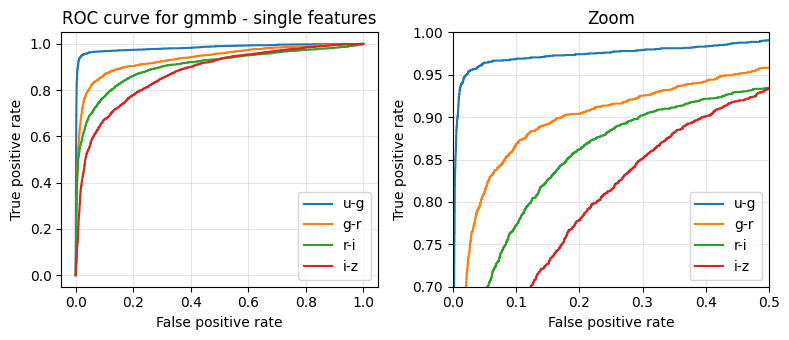

In [23]:
# 10 components
single_ROC(X_train, X_test, y_train, y_test, 'gmmb', 10)

This shows that for the gmmb classifier, too, the $(u-g)$ feature is the most informative one.

Now, we can have an idea of how many features are needed to train the classifier:

Training the data with multiple features:



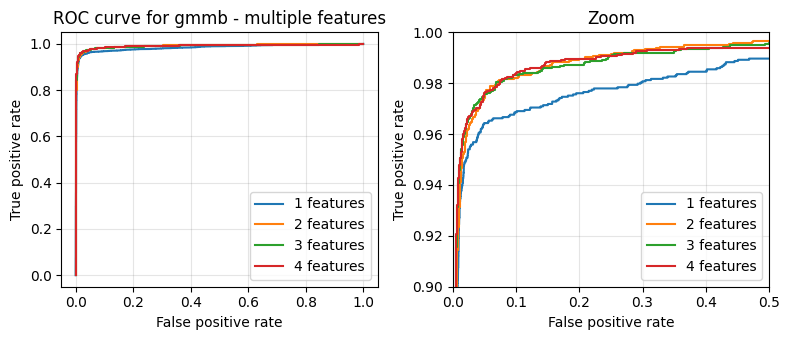

In [24]:
# 10 components
progressive_ROC(X_train, X_test, y_train, y_test, 'gmmb', 10)

So, in this case, we can see that a single feature isn't enough, but training on 2, 3, or 4 features yields very similar results. 

As a last preliminar check, we can see how the performance varies with the number of components (training the classifier on all the features):

Training the data with different numbers of components:



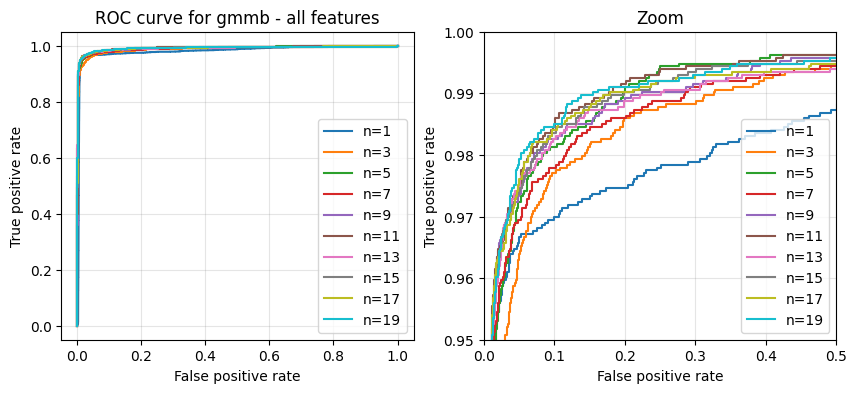

In [25]:
components = np.arange(1, 21, 2, dtype = int)

print('Training the data with different numbers of components:\n')

fig, ax = plt.subplots(1, 2, figsize = (10, 4))

classifier = 'gmmb'

for n in components:
    
    gmmb = GMMBayes(n_components=n)
    gmmb.fit(X_train, y_train)
    y_prob = gmmb.predict_proba(X_test)[:, 1] 

    fpr, tpr, thresh = roc_curve(y_test, y_prob)
    ax[0].plot(fpr, tpr, label='n=%i' % n)
    ax[1].plot(fpr, tpr, label='n=%i' % n)

ax[0].set_xlabel('False positive rate')
ax[0].set_ylabel('True positive rate')
ax[0].set_title('ROC curve for ' + classifier + ' - all features')
ax[0].legend(loc='best')
ax[0].grid(c='grey', alpha = 0.2)

ax[1].set_xlabel('False positive rate')
ax[1].set_ylabel('True positive rate')
ax[1].set_title('Zoom')
ax[1].legend(loc='best')
ax[1].grid(c='grey', alpha = 0.2)
ax[1].set_ylim(0.95, 1)
ax[1].set_xlim(0, 0.5)

plt.show()

This tells us that the classifier trained with a single gaussian gives us the worst results, while increasing the number of gaussians give us more or less the same results.

Now, we can cross-validate; we'll do so on the best number of features to train the classifier on, and on the best number of gaussian components.

In [26]:
n_splits = 10

n_components = np.arange(1, 21, dtype = int)

auc_roc_cv_matrix = np.empty((len(n_components), 4))
accuracy_cv_matrix = np.empty((len(n_components), 4))
precision_cv_matrix = np.empty((len(n_components), 4))
completeness_cv_matrix = np.empty((len(n_components), 4))

kf = KFold(n_splits=n_splits, shuffle=True, random_state=336)

for i, n in tqdm(enumerate(n_components), total = len(n_components)):     # Cycling on the components -> i
  
    gmmb = GMMBayes(n_components=n)

    for j in range(4):     # Cycling on the number of features -> j

        accuracy = []
        precision = []
        completeness = []
        auc_roc = []
        
        for train_index, test_index in kf.split(X_train):
            X_train_cv, X_test_cv = X_train[train_index], X_train[test_index]
            y_train_cv, y_test_cv = y_train[train_index], y_train[test_index]
            
            gmmb.fit(X_train_cv[:, 0:j+1], y_train_cv)
            y_pred_test_cv = gmmb.predict(X_test_cv[:, 0:j+1])
            y_prob_test_cv = gmmb.predict_proba(X_test_cv[:, 0:j+1])[:, 1] 
            
            accuracy.append(accuracy_score(y_test_cv, y_pred_test_cv))
            precision.append(precision_score(y_test_cv, y_pred_test_cv))
            completeness.append(recall_score(y_test_cv, y_pred_test_cv))
    
            fpr, tpr, _ = roc_curve(y_test_cv, y_prob_test_cv)
            auc_roc.append(auc(fpr, tpr))

        accuracy_cv_matrix[i, j] = np.mean(accuracy)
        precision_cv_matrix[i, j] = np.mean(precision)
        completeness_cv_matrix[i, j] = np.mean(completeness)
        auc_roc_cv_matrix[i, j] = np.mean(auc_roc)

  0%|          | 0/20 [00:00<?, ?it/s]

In [27]:
accuracy_cv_matrix

array([[0.98111429, 0.98128571, 0.9812    , 0.98028571],
       [0.97991429, 0.97842857, 0.97585714, 0.97291429],
       [0.98071429, 0.9806    , 0.97448571, 0.97231429],
       [0.98105714, 0.9796    , 0.97974286, 0.9818    ],
       [0.98068571, 0.98177143, 0.98251429, 0.98094286],
       [0.98071429, 0.98205714, 0.9828    , 0.98165714],
       [0.98094286, 0.98251429, 0.98311429, 0.98217143],
       [0.98077143, 0.98251429, 0.98331429, 0.98305714],
       [0.98111429, 0.98222857, 0.98297143, 0.98225714],
       [0.98097143, 0.98222857, 0.98391429, 0.98308571],
       [0.98088571, 0.98305714, 0.98322857, 0.98362857],
       [0.9814    , 0.98282857, 0.98402857, 0.98414286],
       [0.98117143, 0.9826    , 0.98425714, 0.98482857],
       [0.98131429, 0.9828    , 0.98434286, 0.98402857],
       [0.98117143, 0.98277143, 0.98391429, 0.98477143],
       [0.98134286, 0.98274286, 0.98417143, 0.98505714],
       [0.9814    , 0.98291429, 0.98425714, 0.98468571],
       [0.98111429, 0.98277143,

In [28]:
precision_cv_matrix

array([[0.93762748, 0.93663279, 0.93575829, 0.9308402 ],
       [0.9502279 , 0.92843932, 0.90377822, 0.88460912],
       [0.94942018, 0.93692524, 0.88581052, 0.87593904],
       [0.9450744 , 0.9240339 , 0.92923175, 0.94717677],
       [0.93173081, 0.94491919, 0.945267  , 0.94062354],
       [0.93005959, 0.94422479, 0.94786134, 0.93986738],
       [0.93388075, 0.94416502, 0.9496928 , 0.94341269],
       [0.94097468, 0.94431859, 0.94965739, 0.94613303],
       [0.9435199 , 0.94167127, 0.94563131, 0.94097097],
       [0.94308563, 0.94300686, 0.95061201, 0.9469544 ],
       [0.94182371, 0.94400561, 0.94614863, 0.9482438 ],
       [0.94232713, 0.94374128, 0.95081399, 0.95095717],
       [0.93988382, 0.94506849, 0.95241233, 0.95434079],
       [0.93990254, 0.94583211, 0.95282549, 0.95134333],
       [0.93805527, 0.94463614, 0.95140799, 0.95431153],
       [0.93793235, 0.9488148 , 0.9528437 , 0.95597969],
       [0.93810441, 0.94746757, 0.9537324 , 0.95565431],
       [0.93670585, 0.94850674,

In [29]:
completeness_cv_matrix

array([[0.9293402 , 0.9317027 , 0.9321271 , 0.93092879],
       [0.9067212 , 0.92021077, 0.93027967, 0.93322114],
       [0.91351908, 0.92629005, 0.94278818, 0.93959533],
       [0.92078614, 0.93402976, 0.92990134, 0.92409295],
       [0.93299406, 0.92647103, 0.93187145, 0.92480968],
       [0.93513204, 0.92919441, 0.93070341, 0.93086543],
       [0.93234509, 0.93258383, 0.93090512, 0.93095577],
       [0.9233118 , 0.93238338, 0.93227046, 0.93440808],
       [0.92300866, 0.93312714, 0.93430379, 0.93418159],
       [0.92235276, 0.93174115, 0.93586586, 0.93342494],
       [0.92329371, 0.93664525, 0.93577271, 0.93636283],
       [0.9263486 , 0.93525003, 0.93653884, 0.93710806],
       [0.92735507, 0.93223008, 0.93624524, 0.93843864],
       [0.9282633 , 0.93282635, 0.93646146, 0.93559472],
       [0.92936272, 0.93395524, 0.93485289, 0.93801463],
       [0.93066159, 0.92899391, 0.93521445, 0.93834658],
       [0.93088365, 0.93183612, 0.93480883, 0.93605091],
       [0.93058259, 0.92966213,

In [30]:
auc_roc_cv_matrix

array([[0.9803124 , 0.98064944, 0.9802468 , 0.98049664],
       [0.98320607, 0.98454995, 0.98775577, 0.98482963],
       [0.9832842 , 0.98745751, 0.98828253, 0.98807439],
       [0.98248366, 0.98767574, 0.98940391, 0.98932709],
       [0.98281703, 0.9898581 , 0.99037383, 0.98901337],
       [0.9838009 , 0.98995881, 0.99053405, 0.98975445],
       [0.98383774, 0.99005728, 0.99046042, 0.99013223],
       [0.98383035, 0.98989012, 0.99048982, 0.98954026],
       [0.98417592, 0.99022474, 0.99048195, 0.99061522],
       [0.98412249, 0.98987254, 0.99145165, 0.9904745 ],
       [0.98429752, 0.98976615, 0.99069151, 0.99018645],
       [0.98421772, 0.98974255, 0.9909503 , 0.99018324],
       [0.98445636, 0.99008436, 0.99033634, 0.99052213],
       [0.98415863, 0.98981911, 0.99087871, 0.99045529],
       [0.98414266, 0.98985488, 0.99017768, 0.98975726],
       [0.98413912, 0.9896274 , 0.99015806, 0.98960999],
       [0.98392433, 0.98950731, 0.99025492, 0.99051038],
       [0.98394816, 0.98944654,

In [31]:
# All the metrics are very similar -> no problems in using accuracy: 

best_index_flat = np.argmax(accuracy_cv_matrix) 
best_index_2d = np.unravel_index(best_index_flat, accuracy_cv_matrix.shape)

best_n_components = n_components[best_index_2d[0]]
best_n_features = best_index_2d[1]+1
print('Numbers of components considered:')
print(n_components)
print('\nBest number of components: %i' % best_n_components) 
print('Best numbers of features to train the classifier on: %i' % best_n_features)

Numbers of components considered:
[ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20]

Best number of components: 19
Best numbers of features to train the classifier on: 4


With this results, we can train the GMMBayes classifier:

In [32]:
gmmb_results_train = []
gmmb_results_test = []
# Same as before: single line, but easier dataframe - or at least, more coherent with the others

gmmb = GMMBayes(n_components = best_n_components)
gmmb.fit(X_train[:, 0:best_n_features], y_train)

y_train_pred_gmmb_best = gmmb.predict(X_train[:, 0:best_n_features])
y_test_pred_gmmb_best = gmmb.predict(X_test[:, 0:best_n_features])

gmmb_results_train.append(table_results(y_train, y_train_pred_gmmb_best))
gmmb_results_test.append(table_results(y_test, y_test_pred_gmmb_best))

In [33]:
clf_names = ['GMMB']
clf_notes = ['18 components - all features']

gmmb_results_train_df = pd.DataFrame(gmmb_results_train, columns = ['Accuracy', 'Contamination', 'Completeness', 'True negatives', 'False positives', 'False negatives', 'True positives'])
gmmb_results_train_df[['Accuracy', 'Contamination', 'Completeness']] = gmmb_results_train_df[['Accuracy', 'Contamination', 'Completeness']].round(3)
gmmb_results_train_df.insert(0, 'Classifier', clf_names)
gmmb_results_train_df.insert(1, 'Notes', clf_notes)

gmmb_results_test_df = pd.DataFrame(gmmb_results_test, columns = ['Accuracy', 'Contamination', 'Completeness', 'True negatives', 'False positives', 'False negatives', 'True positives'])
gmmb_results_test_df[['Accuracy', 'Contamination', 'Completeness']] = gmmb_results_test_df[['Accuracy', 'Contamination', 'Completeness']].round(3)
gmmb_results_test_df.insert(0, 'Classifier', clf_names)
gmmb_results_test_df.insert(1, 'Notes', clf_notes)

In [34]:
display(Markdown('### GMMB - Train results:'))
display(gmmb_results_train_df)

display(Markdown('### GMMB - Test results:'))
display(gmmb_results_test_df)

### GMMB - Train results:

,Classifier,Notes,Accuracy,Contamination,Completeness,True negatives,False positives,False negatives,True positives
0,GMMB,18 components - all features,0.986,0.039,0.938,29804,193,309,4694


### GMMB - Test results:

,Classifier,Notes,Accuracy,Contamination,Completeness,True negatives,False positives,False negatives,True positives
0,GMMB,18 components - all features,0.985,0.039,0.936,12787,82,136,1995


This results are the best obtained up until now and (as opposed as I suspected, given the high number of components) the classifier doesn't seem to be overfitting. Let's display the results:

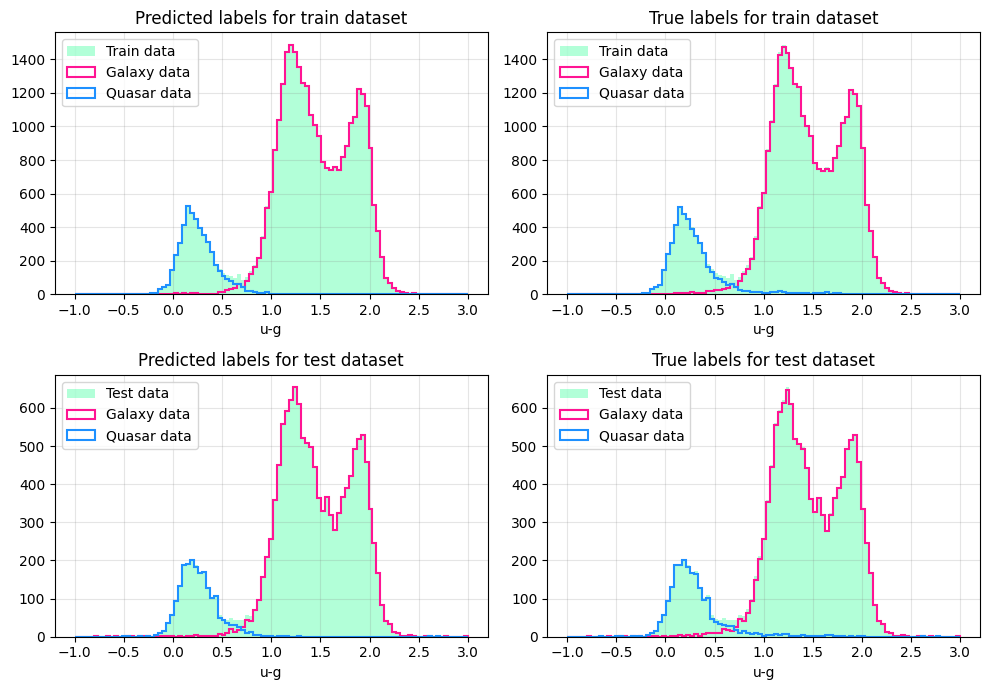

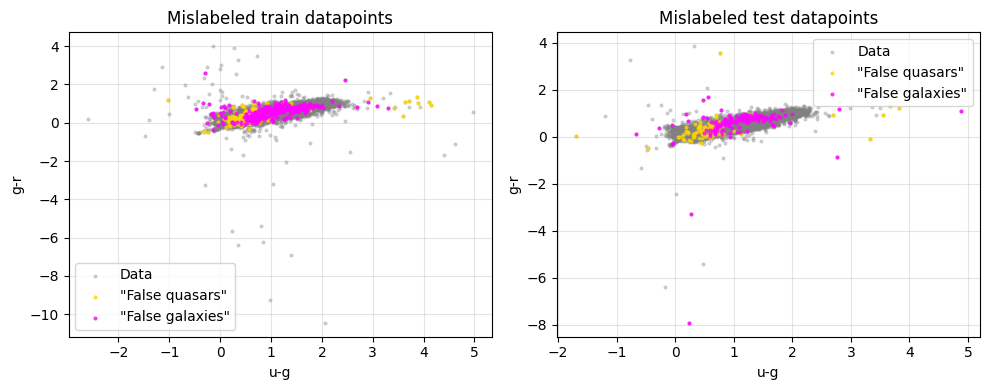

In [35]:
plot_classified_hists(X_train, X_test, y_train, y_test, y_train_pred_gmmb_best, y_test_pred_gmmb_best, 'u-g')

mislabeled_points(X_train, X_test, y_train, y_test, y_train_pred_gmmb_best, y_test_pred_gmmb_best, 'u-g', 'g-r')


## K-nearest neighbors classifier


For this classifier, too, we need to decide what is the best number of neighbors to use.

As before, we'll plot the ROC curves to get an idea of how the classifiers behave. First, the classifier with n_neighbors fixed, and varying features:

Training the data with a single feature:



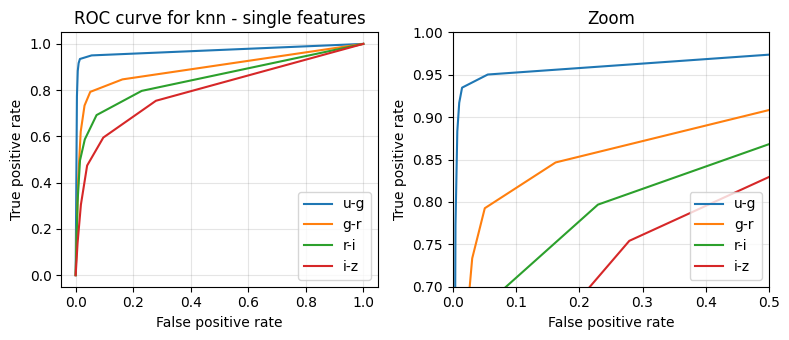

In [36]:
# 5 nearest neighbors
single_ROC(X_train, X_test, y_train, y_test, 'knn', 5)

Then we can plot the ROC curves for n_neighbors fixed, varying how many features we use to train the classifier:

Training the data with multiple features:



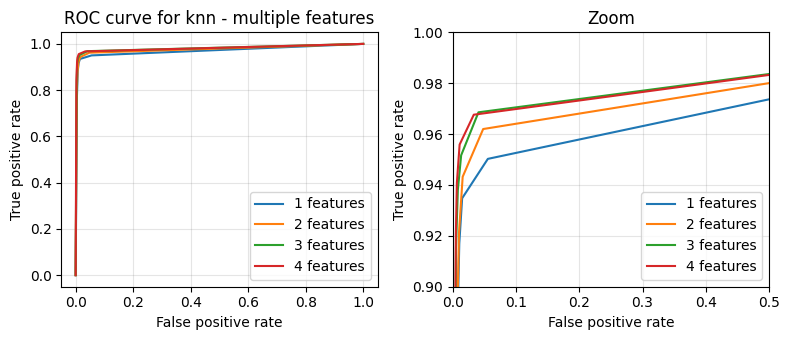

In [37]:
progressive_ROC(X_train, X_test, y_train, y_test, 'knn', 5)

This shows that, as before, training the classifier on a single feature isn't enough. We'll have to cross-validate on this value, too.

Last check to see how the performance varies: changing n_neighbors (and using all features):

Training the data with different numbers of neighbors:



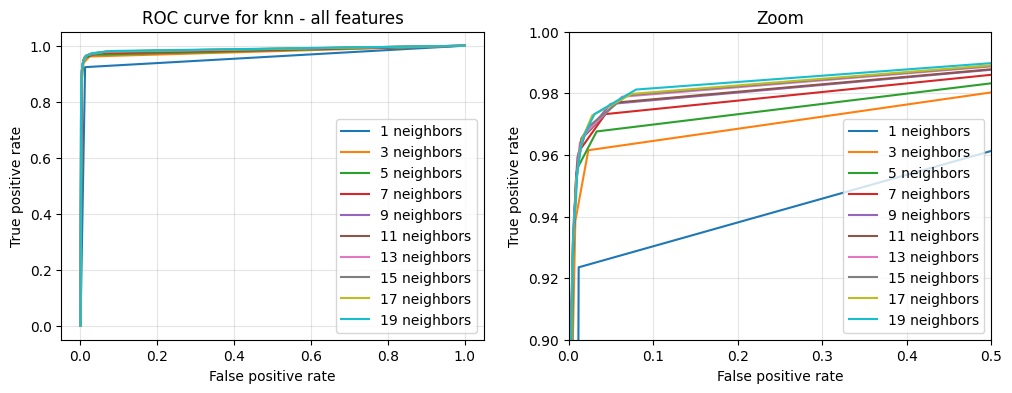

In [38]:
neighbors = np.arange(1, 21, 2, dtype = int)

print('Training the data with different numbers of neighbors:\n')

fig, ax = plt.subplots(1, 2, figsize = (12, 4))

classifier = 'knn'

for n in neighbors:
    
    knn = KNeighborsClassifier(n_neighbors = n)
    knn.fit(X_train, y_train)
    y_prob = knn.predict_proba(X_test)[:, 1] 

    fpr, tpr, thresh = roc_curve(y_test, y_prob)
    ax[0].plot(fpr, tpr, label='%i neighbors' % n)
    ax[1].plot(fpr, tpr, label='%i neighbors' % n)

ax[0].set_xlabel('False positive rate')
ax[0].set_ylabel('True positive rate')
ax[0].set_title('ROC curve for ' + classifier + ' - all features')
ax[0].legend(loc='best')
ax[0].grid(c='grey', alpha = 0.2)

ax[1].set_xlabel('False positive rate')
ax[1].set_ylabel('True positive rate')
ax[1].set_title('Zoom')
ax[1].legend(loc='best')
ax[1].grid(c='grey', alpha = 0.2)
ax[1].set_ylim(0.9, 1)
ax[1].set_xlim(0, 0.5)

plt.show()

So, by this plot, it seems that increasing the number of nearest neighbors yields better results. We can now check with cross-validation:

In [39]:
n_splits = 10

n1 = np.arange(1, 20, dtype = int)
n2 = np.arange(20, 101, 5, dtype = int)
n_neighbors = np.concatenate([n1, n2])

auc_roc_cv_matrix = np.empty((len(n_neighbors), 4))
accuracy_cv_matrix = np.empty((len(n_neighbors), 4))
precision_cv_matrix = np.empty((len(n_neighbors), 4))
completeness_cv_matrix = np.empty((len(n_neighbors), 4))

kf = KFold(n_splits=n_splits, shuffle=True, random_state=336)

for i, nn in tqdm(enumerate(n_neighbors), total = len(n_neighbors)):     # Cycling on the components -> i
  
    knn = KNeighborsClassifier(n_neighbors = nn)

    for j in range(4):     # Cycling on the number of features -> j

        accuracy = []
        precision = []
        completeness = []
        auc_roc = []
        
        for train_index, test_index in kf.split(X_train):
            X_train_cv, X_test_cv = X_train[train_index], X_train[test_index]
            y_train_cv, y_test_cv = y_train[train_index], y_train[test_index]
            
            knn.fit(X_train_cv[:, 0:j+1], y_train_cv)
            y_pred_test_cv = knn.predict(X_test_cv[:, 0:j+1])
            y_prob_test_cv = knn.predict_proba(X_test_cv[:, 0:j+1])[:, 1] 
            
            accuracy.append(accuracy_score(y_test_cv, y_pred_test_cv))
            precision.append(precision_score(y_test_cv, y_pred_test_cv))
            completeness.append(recall_score(y_test_cv, y_pred_test_cv))
    
            fpr, tpr, _ = roc_curve(y_test_cv, y_prob_test_cv)
            auc_roc.append(auc(fpr, tpr))

        accuracy_cv_matrix[i, j] = np.mean(accuracy)
        precision_cv_matrix[i, j] = np.mean(precision)
        completeness_cv_matrix[i, j] = np.mean(completeness)
        auc_roc_cv_matrix[i, j] = np.mean(auc_roc)

  0%|          | 0/36 [00:00<?, ?it/s]

In [40]:
accuracy_cv_matrix

array([[0.96957143, 0.97154286, 0.9764    , 0.97928571],
       [0.9724    , 0.975     , 0.97891429, 0.98157143],
       [0.97922857, 0.98037143, 0.98202857, 0.98485714],
       [0.97925714, 0.97988571, 0.98288571, 0.98517143],
       [0.98048571, 0.98097143, 0.98374286, 0.98602857],
       [0.98068571, 0.98062857, 0.98357143, 0.98605714],
       [0.98111429, 0.98102857, 0.98394286, 0.9858    ],
       [0.98094286, 0.9812    , 0.98428571, 0.98574286],
       [0.98111429, 0.98177143, 0.98417143, 0.98568571],
       [0.98102857, 0.98162857, 0.98394286, 0.98548571],
       [0.98102857, 0.98165714, 0.98394286, 0.98582857],
       [0.98085714, 0.98174286, 0.98405714, 0.98562857],
       [0.98122857, 0.98214286, 0.98408571, 0.98571429],
       [0.98122857, 0.98202857, 0.98428571, 0.98568571],
       [0.98122857, 0.98222857, 0.98397143, 0.98568571],
       [0.98154286, 0.982     , 0.98431429, 0.98562857],
       [0.98105714, 0.98222857, 0.98411429, 0.98542857],
       [0.98111429, 0.98217143,

In [41]:
precision_cv_matrix

array([[0.89368178, 0.9007431 , 0.91818312, 0.92800883],
       [0.95218532, 0.95576915, 0.96546728, 0.96891132],
       [0.93581715, 0.93876104, 0.94408483, 0.95544523],
       [0.95117804, 0.95253427, 0.96037369, 0.96856833],
       [0.9406014 , 0.94038494, 0.95192712, 0.95991646],
       [0.95194952, 0.94933927, 0.95862471, 0.9668231 ],
       [0.94471736, 0.94092372, 0.95285418, 0.95943287],
       [0.94995623, 0.94881723, 0.95829611, 0.96424837],
       [0.94360632, 0.94368257, 0.95281126, 0.95981771],
       [0.94776708, 0.94839569, 0.95650659, 0.96242066],
       [0.94288057, 0.94276832, 0.95180733, 0.96065219],
       [0.94697969, 0.94757661, 0.95557316, 0.96248399],
       [0.94291262, 0.94491686, 0.95259761, 0.96002286],
       [0.94618585, 0.94779262, 0.95637478, 0.9625258 ],
       [0.9419936 , 0.94495936, 0.95273258, 0.95965582],
       [0.94726059, 0.94671828, 0.95564992, 0.96192012],
       [0.94089986, 0.94460354, 0.95316393, 0.95898369],
       [0.94452467, 0.94679367,

In [42]:
completeness_cv_matrix

array([[0.89283824, 0.90029547, 0.91629942, 0.9264175 ],
       [0.84920707, 0.86502024, 0.88393297, 0.89972044],
       [0.91720177, 0.92278582, 0.92888166, 0.93735673],
       [0.90082264, 0.90420439, 0.91772159, 0.92591638],
       [0.9213804 , 0.92528708, 0.93298238, 0.94117901],
       [0.91063549, 0.91298981, 0.92456592, 0.93424809],
       [0.92150512, 0.92515899, 0.93336324, 0.94001294],
       [0.91451312, 0.91771833, 0.93021149, 0.93456446],
       [0.92262666, 0.92747357, 0.93517866, 0.93875199],
       [0.91743633, 0.92120949, 0.92953566, 0.93456183],
       [0.92287782, 0.9276536 , 0.93447175, 0.93893568],
       [0.91712338, 0.92307623, 0.9313282 , 0.93555235],
       [0.92429415, 0.92889275, 0.93475565, 0.93880517],
       [0.92072696, 0.92483075, 0.9321713 , 0.93599729],
       [0.92533189, 0.92945114, 0.93377046, 0.9389786 ],
       [0.92197744, 0.92583555, 0.93316565, 0.936236  ],
       [0.92534091, 0.92987223, 0.93440363, 0.93779275],
       [0.92174029, 0.92708482,

In [43]:
auc_roc_cv_matrix

array([[0.93758684, 0.94184144, 0.95134908, 0.95724502],
       [0.96146673, 0.96746642, 0.97044051, 0.97263212],
       [0.9680433 , 0.97261331, 0.97574254, 0.97782089],
       [0.97049806, 0.97483085, 0.97775482, 0.97943808],
       [0.97158673, 0.97603497, 0.97891133, 0.98108976],
       [0.97283916, 0.97670133, 0.97973034, 0.98225254],
       [0.97360064, 0.97755656, 0.9812105 , 0.9828932 ],
       [0.97418975, 0.97844862, 0.98185336, 0.98369598],
       [0.97432047, 0.97952389, 0.98252185, 0.98444752],
       [0.97467865, 0.98018416, 0.9830839 , 0.98488994],
       [0.97486124, 0.9806155 , 0.98355905, 0.98534499],
       [0.97507989, 0.9808818 , 0.98397179, 0.98551328],
       [0.97532143, 0.98132094, 0.98429853, 0.9858166 ],
       [0.97563209, 0.98154865, 0.98447613, 0.98598556],
       [0.9759296 , 0.98181641, 0.98480612, 0.98645694],
       [0.9763284 , 0.98214091, 0.98496425, 0.98642745],
       [0.97632615, 0.98252785, 0.98511641, 0.98658045],
       [0.97645175, 0.98268058,

In [44]:
best_index_flat = np.argmax(accuracy_cv_matrix) 
best_index_2d = np.unravel_index(best_index_flat, accuracy_cv_matrix.shape)

best_n_neighbors_acc = n_neighbors[best_index_2d[0]]
best_n_features_acc = best_index_2d[1]+1
print('Numbers of neighbors considered:')
print(n_neighbors)
print('\nBest number of neighbors: %i' % best_n_neighbors_acc) 
print('Best numbers of features to train the classifier on: %i' % best_n_features_acc)

Numbers of neighbors considered:
[  1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17  18
  19  20  25  30  35  40  45  50  55  60  65  70  75  80  85  90  95 100]

Best number of neighbors: 6
Best numbers of features to train the classifier on: 4


If we consider the accuracy as the scoring metric, we get that the best number of nearest neighbors is $6$; the ROC curves, however, suggested that a higher number of nearest neighbors would perform better. Let's see what the best hyperparameters are, based on the other metrics:

In [45]:
print('Numbers of neighbors considered:')
print(n_neighbors)

#-----

best_index_flat = np.argmax(auc_roc_cv_matrix) 
best_index_2d = np.unravel_index(best_index_flat, auc_roc_cv_matrix.shape)

best_n_neighbors_auc = n_neighbors[best_index_2d[0]]
best_n_features_auc = best_index_2d[1]+1

print('\nAUC-ROC:')
print('  Best number of neighbors: %i' % best_n_neighbors_auc) 
print('  Best numbers of features to train the classifier on: %i' % best_n_features_auc)

#-----

best_index_flat = np.argmax(precision_cv_matrix) 
best_index_2d = np.unravel_index(best_index_flat, precision_cv_matrix.shape)

best_n_neighbors_cont = n_neighbors[best_index_2d[0]]
best_n_features_cont = best_index_2d[1]+1

# Contamination = 1-precision
print('\nContamination:')
print('  Best number of neighbors: %i' % best_n_neighbors_cont) 
print('  Best numbers of features to train the classifier on: %i' % best_n_features_cont)

#-----

best_index_flat = np.argmax(completeness_cv_matrix) 
best_index_2d = np.unravel_index(best_index_flat, completeness_cv_matrix.shape)

best_n_neighbors_compl = n_neighbors[best_index_2d[0]]
best_n_features_compl = best_index_2d[1]+1

print('\nCompleteness:')
print('  Best number of neighbors: %i' % best_n_neighbors_compl) 
print('  Best numbers of features to train the classifier on: %i' % best_n_features_compl)

Numbers of neighbors considered:
[  1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17  18
  19  20  25  30  35  40  45  50  55  60  65  70  75  80  85  90  95 100]

AUC-ROC:
  Best number of neighbors: 100
  Best numbers of features to train the classifier on: 4

Contamination:
  Best number of neighbors: 2
  Best numbers of features to train the classifier on: 4

Completeness:
  Best number of neighbors: 5
  Best numbers of features to train the classifier on: 4


Indeed, according to the AUC-ROC, the best number of nearest neighbors is $100$ - and probably would have been higher if we considered other values, too. Contamination and completeness, however, "preferred" lower values. 

In [46]:
knn_results_train = []
knn_results_test = []

scoring_metrics = ['Accuracy', 'AUC-ROC', 'Contamination', 'Completeness']

best_nn = [best_n_neighbors_acc, best_n_neighbors_auc, best_n_neighbors_cont, best_n_neighbors_compl]
best_feat = [best_n_features_acc, best_n_features_auc, best_n_features_cont, best_n_features_compl]

for nn, feat in zip(best_nn, best_feat):

    knn = KNeighborsClassifier(n_neighbors = nn)
    knn.fit(X_train[:, 0:feat], y_train)
    
    y_train_pred_knn = knn.predict(X_train[:, 0:feat])
    y_test_pred_knn = knn.predict(X_test[:, 0:feat])
    
    knn_results_train.append(table_results(y_train, y_train_pred_knn))
    knn_results_test.append(table_results(y_test, y_test_pred_knn))

In [47]:
clf_names = ['KNN', 'KNN', 'KNN', 'KNN']
clf_notes = ['6 NN, all features', '100 NN, all features', '2 NN, all features', '5 NN, all features']

knn_results_train_df = pd.DataFrame(knn_results_train, columns = ['Accuracy', 'Contamination', 'Completeness', 'True negatives', 'False positives', 'False negatives', 'True positives'])
knn_results_train_df[['Accuracy', 'Contamination', 'Completeness']] = knn_results_train_df[['Accuracy', 'Contamination', 'Completeness']].round(3)
knn_results_train_df.insert(0, 'Classifier', clf_names)
knn_results_train_df.insert(1, 'Scoring metric', scoring_metrics)
knn_results_train_df.insert(2, 'Notes', clf_notes)

knn_results_test_df = pd.DataFrame(knn_results_test, columns = ['Accuracy', 'Contamination', 'Completeness', 'True negatives', 'False positives', 'False negatives', 'True positives'])
knn_results_test_df[['Accuracy', 'Contamination', 'Completeness']] = knn_results_test_df[['Accuracy', 'Contamination', 'Completeness']].round(3)
knn_results_test_df.insert(0, 'Classifier', clf_names)
knn_results_test_df.insert(1, 'Scoring metric', scoring_metrics)
knn_results_test_df.insert(2, 'Notes', clf_notes)

In [48]:
display(Markdown('### KNN - Train results:'))
display(knn_results_train_df)

display(Markdown('### KNN - Test results:'))
display(knn_results_test_df)

### KNN - Train results:

,Classifier,Scoring metric,Notes,Accuracy,Contamination,Completeness,True negatives,False positives,False negatives,True positives
0,KNN,Accuracy,"6 NN, all features",0.988,0.026,0.940,29871,126,300,4703
1,KNN,AUC-ROC,"100 NN, all features",0.984,0.049,0.935,29758,239,324,4679
2,KNN,Contamination,"2 NN, all features",0.989,0.000,0.926,29997,0,369,4634
3,KNN,Completeness,"5 NN, all features",0.988,0.031,0.950,29843,154,252,4751


### KNN - Test results:

,Classifier,Scoring metric,Notes,Accuracy,Contamination,Completeness,True negatives,False positives,False negatives,True positives
0,KNN,Accuracy,"6 NN, all features",0.985,0.035,0.931,12797,72,146,1985
1,KNN,AUC-ROC,"100 NN, all features",0.983,0.049,0.932,12766,103,145,1986
2,KNN,Contamination,"2 NN, all features",0.981,0.034,0.898,12801,68,217,1914
3,KNN,Completeness,"5 NN, all features",0.986,0.040,0.941,12785,84,126,2005


Again, all the results are fairly similar and there's no evident overfitting. We'll just stick to the results cross-validated on the accuracy. Here's the plots:

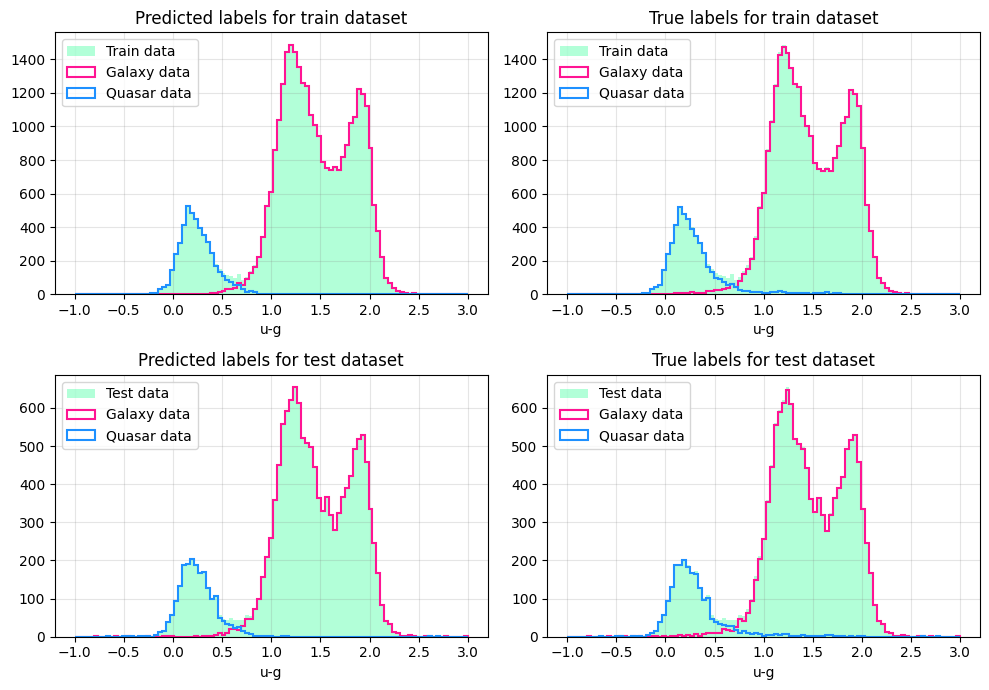

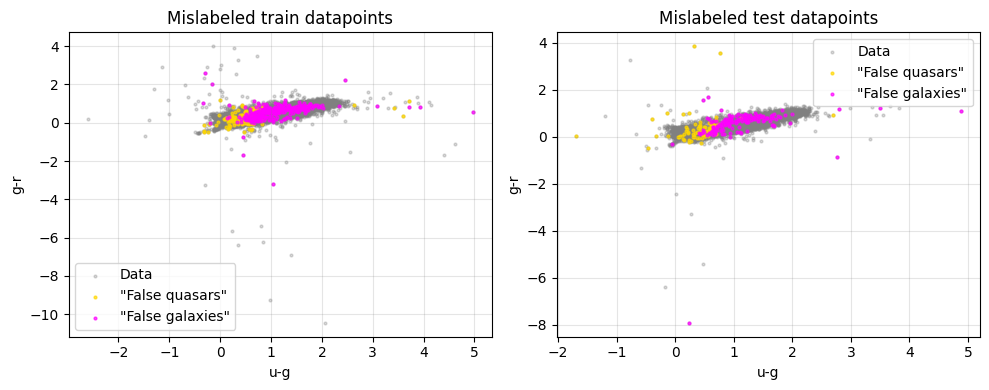

In [49]:
knn = KNeighborsClassifier(n_neighbors = best_n_neighbors_acc)
knn.fit(X_train[:, 0:best_n_features_acc], y_train)

y_train_pred_knn_best = knn.predict(X_train[:, 0:best_n_features_acc])
y_test_pred_knn_best = knn.predict(X_test[:, 0:best_n_features_acc])

plot_classified_hists(X_train, X_test, y_train, y_test, y_train_pred_knn_best, y_test_pred_knn_best, 'u-g')

mislabeled_points(X_train, X_test, y_train, y_test, y_train_pred_knn_best, y_test_pred_knn_best, 'u-g', 'g-r')

In [50]:
# For the DataFrame in the summary:
# Dropping the scoring metric column
knn_results_train_df = knn_results_train_df.drop(columns=['Scoring metric'])
knn_results_test_df = knn_results_test_df.drop(columns=['Scoring metric'])

# Dropping all rows except for the one cross-validated on accuracy (so, index = 0):
knn_results_train_df = knn_results_train_df.drop(index = 3)
knn_results_train_df = knn_results_train_df.drop(index = 2)
knn_results_train_df = knn_results_train_df.drop(index = 1)

knn_results_test_df = knn_results_test_df.drop(index = 3)
knn_results_test_df = knn_results_test_df.drop(index = 2)
knn_results_test_df = knn_results_test_df.drop(index = 1)


## Random forest

As a last attempt, we can check how a random forest (and, later, boosting) would perform on this dataset. As done before, let's first check the ROC curves for:

- Different features;
- Different number of features;
- In this case, different maximum depths for the trees.


Training the data with a single feature:



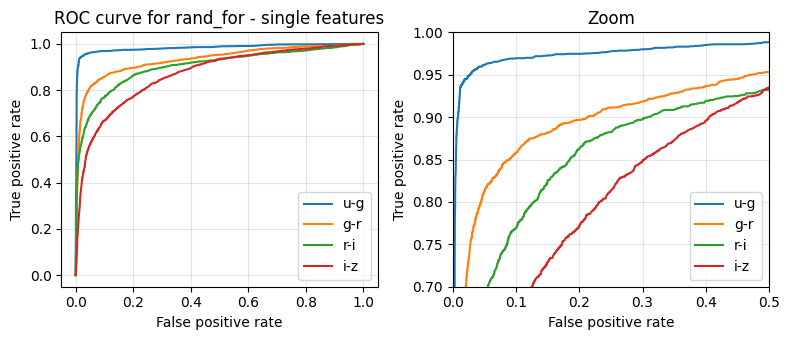

In [51]:
# Max depth = 10
single_ROC(X_train, X_test, y_train, y_test, 'rand_for', 10)

Training the data with multiple features:



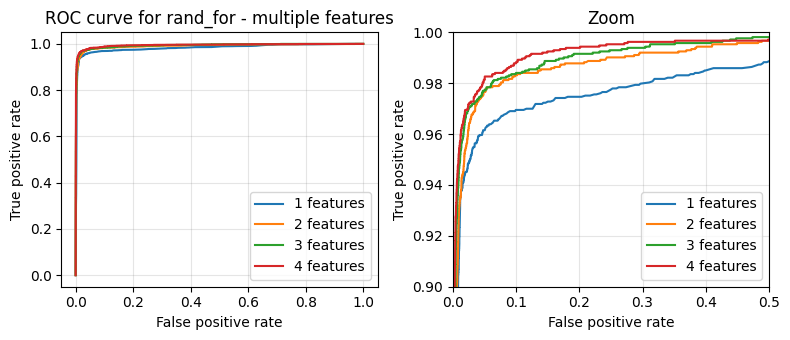

In [52]:
progressive_ROC(X_train, X_test, y_train, y_test, 'rand_for', 10)

Training the data with different maximum depths for the trees (and all features):



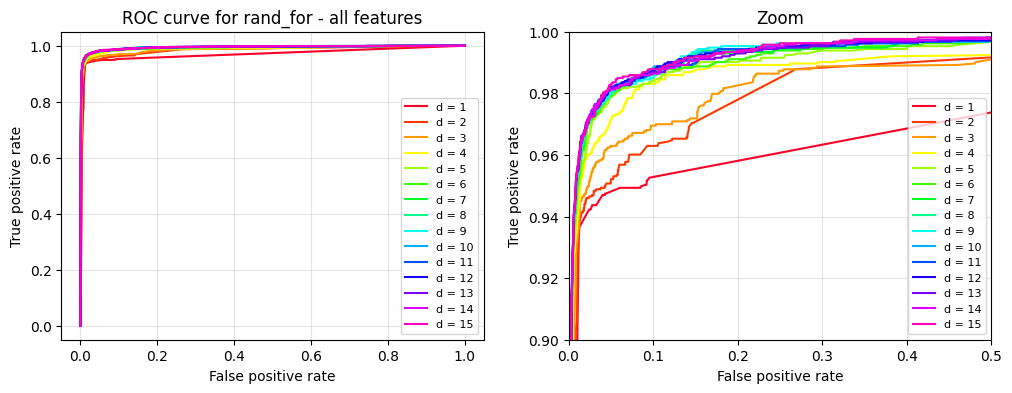

In [53]:
depth_range = np.arange(1, 16, dtype = int)

print('Training the data with different maximum depths for the trees (and all features):\n')

fig, ax = plt.subplots(1, 2, figsize = (12, 4))

classifier = 'rand_for'
plot_colors = plt.cm.gist_rainbow(np.linspace(0, 1, len(depth_range)))
# There were too many curves to plot, the automatic color got repeated

for i, depth in enumerate(depth_range):
    
    rand_for = RandomForestClassifier(max_depth = depth, min_samples_split = 20, criterion = 'entropy', random_state = 336, n_jobs = -1) 
    rand_for.fit(X_train, y_train)
    y_prob = rand_for.predict_proba(X_test)[:, 1] 

    fpr, tpr, thresh = roc_curve(y_test, y_prob)
    ax[0].plot(fpr, tpr, label='d = %i' % depth, color = plot_colors[i])
    ax[1].plot(fpr, tpr, label='d = %i' % depth, color = plot_colors[i])

ax[0].set_xlabel('False positive rate')
ax[0].set_ylabel('True positive rate')
ax[0].set_title('ROC curve for ' + classifier + ' - all features')
ax[0].legend(loc='lower right', fontsize = 8)
ax[0].grid(c='grey', alpha = 0.2)

ax[1].set_xlabel('False positive rate')
ax[1].set_ylabel('True positive rate')
ax[1].set_title('Zoom')
ax[1].legend(loc='lower right', fontsize = 8)
ax[1].grid(c='grey', alpha = 0.2)
ax[1].set_ylim(0.9, 1)
ax[1].set_xlim(0, 0.5)

plt.show()

These curves show that:

- The best single feature to train the classifier on is still $(u-g)$;
- Training on a single feature isn't enough, but the results of the training on more features is similar;
- Having max_depth $<3$ yields poorer results, while for higher depths the results are quite similar.

Knowing this, we can cross-validate on the number of features and the max_depth parameter:

In [54]:
n_splits = 10

depths_range = np.arange(1, 16, dtype = int)

auc_roc_cv_matrix = np.empty((len(depths_range), 4))
accuracy_cv_matrix = np.empty((len(depths_range), 4))
precision_cv_matrix = np.empty((len(depths_range), 4))
completeness_cv_matrix = np.empty((len(depths_range), 4))

kf = KFold(n_splits=n_splits, shuffle=True, random_state=336)

for i, depth in tqdm(enumerate(depths_range), total = len(depths_range)):     # Cycling on the components -> i
  
    rand_for = RandomForestClassifier(max_depth = depth, min_samples_split = 20, criterion = 'entropy', random_state = 336, n_jobs = -1)

    for j in range(4):     # Cycling on the number of features -> j

        accuracy = []
        precision = []
        completeness = []
        auc_roc = []
        
        for train_index, test_index in kf.split(X_train):
            X_train_cv, X_test_cv = X_train[train_index], X_train[test_index]
            y_train_cv, y_test_cv = y_train[train_index], y_train[test_index]
            
            rand_for.fit(X_train_cv[:, 0:j+1], y_train_cv)
            y_pred_test_cv = rand_for.predict(X_test_cv[:, 0:j+1])
            y_prob_test_cv = rand_for.predict_proba(X_test_cv[:, 0:j+1])[:, 1] 
            
            accuracy.append(accuracy_score(y_test_cv, y_pred_test_cv))
            precision.append(precision_score(y_test_cv, y_pred_test_cv))
            completeness.append(recall_score(y_test_cv, y_pred_test_cv))
    
            fpr, tpr, _ = roc_curve(y_test_cv, y_prob_test_cv)
            auc_roc.append(auc(fpr, tpr))

        accuracy_cv_matrix[i, j] = np.mean(accuracy)
        precision_cv_matrix[i, j] = np.mean(precision)
        completeness_cv_matrix[i, j] = np.mean(completeness)
        auc_roc_cv_matrix[i, j] = np.mean(auc_roc)

  0%|          | 0/15 [00:00<?, ?it/s]

In [55]:
accuracy_cv_matrix

array([[0.98105714, 0.96365714, 0.97385714, 0.97405714],
       [0.98108571, 0.98108571, 0.97505714, 0.98117143],
       [0.98085714, 0.98131429, 0.9802    , 0.98222857],
       [0.98094286, 0.98208571, 0.98188571, 0.98374286],
       [0.98088571, 0.9826    , 0.98305714, 0.98494286],
       [0.98091429, 0.98245714, 0.98357143, 0.98531429],
       [0.98094286, 0.98242857, 0.98402857, 0.98557143],
       [0.9808    , 0.98245714, 0.98362857, 0.98571429],
       [0.98105714, 0.9822    , 0.98391429, 0.98545714],
       [0.9808    , 0.98208571, 0.98377143, 0.98551429],
       [0.98068571, 0.98197143, 0.98402857, 0.9856    ],
       [0.98051429, 0.98202857, 0.98402857, 0.98565714],
       [0.98031429, 0.98208571, 0.98411429, 0.98574286],
       [0.98005714, 0.98197143, 0.98394286, 0.98582857],
       [0.97991429, 0.98191429, 0.98411429, 0.98571429]])

In [56]:
precision_cv_matrix

array([[0.92817582, 0.9422737 , 0.94345229, 0.9426502 ],
       [0.92886295, 0.92884553, 0.94322114, 0.92921829],
       [0.93564397, 0.93131009, 0.94105415, 0.93680137],
       [0.93573374, 0.93833107, 0.9350555 , 0.94749478],
       [0.93674808, 0.94316638, 0.94582691, 0.95534309],
       [0.9372853 , 0.9442096 , 0.95094733, 0.95790193],
       [0.93854534, 0.94399219, 0.95388317, 0.96025095],
       [0.93844726, 0.94455053, 0.95310256, 0.96110752],
       [0.93942829, 0.94406776, 0.95464829, 0.96003919],
       [0.93877413, 0.94350589, 0.95407305, 0.96085429],
       [0.93886806, 0.94274948, 0.95508911, 0.96122042],
       [0.93806862, 0.94311409, 0.9550432 , 0.96129725],
       [0.9377862 , 0.94330769, 0.95588974, 0.96112405],
       [0.9372872 , 0.94325986, 0.95502774, 0.96187154],
       [0.93706643, 0.94345013, 0.9554257 , 0.96144837]])

In [57]:
completeness_cv_matrix

array([[0.93983784, 0.79422479, 0.86893662, 0.87127901],
       [0.93923422, 0.93925348, 0.87819331, 0.93944579],
       [0.92984514, 0.93803754, 0.91866905, 0.93867166],
       [0.93045232, 0.93584977, 0.93806685, 0.93779817],
       [0.92888535, 0.93430553, 0.93468511, 0.93817653],
       [0.92842008, 0.93206846, 0.93286879, 0.93819984],
       [0.92714643, 0.93209796, 0.93304259, 0.93749948],
       [0.92607881, 0.93168057, 0.93107778, 0.93773916],
       [0.92684195, 0.9302671 , 0.9314575 , 0.93696626],
       [0.9256487 , 0.93010105, 0.9310974 , 0.9365848 ],
       [0.92461873, 0.9300764 , 0.9318749 , 0.93674707],
       [0.92427715, 0.93007748, 0.93189082, 0.93716249],
       [0.92301219, 0.9302743 , 0.93167924, 0.93796293],
       [0.92163787, 0.92948259, 0.93129517, 0.93777729],
       [0.92085955, 0.92892767, 0.93208595, 0.93734584]])

In [58]:
auc_roc_cv_matrix

array([[0.96680685, 0.97172306, 0.97167599, 0.97267961],
       [0.97749312, 0.97668213, 0.97748941, 0.98217167],
       [0.98249528, 0.9797736 , 0.98337479, 0.98619897],
       [0.98328147, 0.98669146, 0.98818507, 0.99032188],
       [0.98353284, 0.98788452, 0.98990838, 0.99225615],
       [0.98340167, 0.9887903 , 0.99118286, 0.99327816],
       [0.98327839, 0.98936862, 0.991727  , 0.9935052 ],
       [0.98312069, 0.98918055, 0.99215349, 0.99361407],
       [0.98287043, 0.98890326, 0.99219686, 0.9938564 ],
       [0.98246311, 0.98901923, 0.99193592, 0.99385466],
       [0.98210862, 0.98871292, 0.99198041, 0.99365798],
       [0.9817318 , 0.98867736, 0.99179267, 0.99356282],
       [0.98161766, 0.98859012, 0.99157755, 0.99370885],
       [0.98120742, 0.9885464 , 0.99163285, 0.9933472 ],
       [0.98120795, 0.98818382, 0.99173783, 0.99337331]])

In [59]:
print('Depths considered:')
print(depths_range)

best_index_flat = np.argmax(accuracy_cv_matrix) 
best_index_2d = np.unravel_index(best_index_flat, accuracy_cv_matrix.shape)

best_depth_acc = depths_range[best_index_2d[0]]
best_n_features_acc = best_index_2d[1]+1

print('\nBest maximum depth: %i' % best_depth_acc) 
print('Best numbers of features to train the classifier on: %i' % best_n_features_acc)

Depths considered:
[ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15]

Best maximum depth: 14
Best numbers of features to train the classifier on: 4


Seems coherent with the ROC curves! So we'll take this result.

In [60]:
rf_results_train = []
rf_results_test = []

rand_for = RandomForestClassifier(max_depth = best_depth_acc, min_samples_split = 20, criterion = 'entropy', random_state = 336, n_jobs = -1)
rand_for.fit(X_train[:, 0:best_n_features_acc], y_train)

y_train_pred_rf_best = rand_for.predict(X_train[:, 0:best_n_features_acc])
y_test_pred_rf_best = rand_for.predict(X_test[:, 0:best_n_features_acc])

rf_results_train.append(table_results(y_train, y_train_pred_rf_best))
rf_results_test.append(table_results(y_test, y_test_pred_rf_best))

In [61]:
clf_names = ['RF']
clf_notes = ['Max_depth = 14, all features']

rf_results_train_df = pd.DataFrame(rf_results_train, columns = ['Accuracy', 'Contamination', 'Completeness', 'True negatives', 'False positives', 'False negatives', 'True positives'])
rf_results_train_df[['Accuracy', 'Contamination', 'Completeness']] = rf_results_train_df[['Accuracy', 'Contamination', 'Completeness']].round(3)
rf_results_train_df.insert(0, 'Classifier', clf_names)
rf_results_train_df.insert(1, 'Notes', clf_notes)

rf_results_test_df = pd.DataFrame(rf_results_test, columns = ['Accuracy', 'Contamination', 'Completeness', 'True negatives', 'False positives', 'False negatives', 'True positives'])
rf_results_test_df[['Accuracy', 'Contamination', 'Completeness']] = rf_results_test_df[['Accuracy', 'Contamination', 'Completeness']].round(3)
rf_results_test_df.insert(0, 'Classifier', clf_names)
rf_results_test_df.insert(1, 'Notes', clf_notes)

In [62]:
display(Markdown('### Random forest - Train results:'))
display(rf_results_train_df)

display(Markdown('### Random forest - Test results:'))
display(rf_results_test_df)

### Random forest - Train results:

,Classifier,Notes,Accuracy,Contamination,Completeness,True negatives,False positives,False negatives,True positives
0,RF,"Max_depth = 14, all features",0.99,0.024,0.951,29881,116,247,4756


### Random forest - Test results:

,Classifier,Notes,Accuracy,Contamination,Completeness,True negatives,False positives,False negatives,True positives
0,RF,"Max_depth = 14, all features",0.986,0.037,0.936,12793,76,137,1994


These results are really good, with no (evident) overfitting!

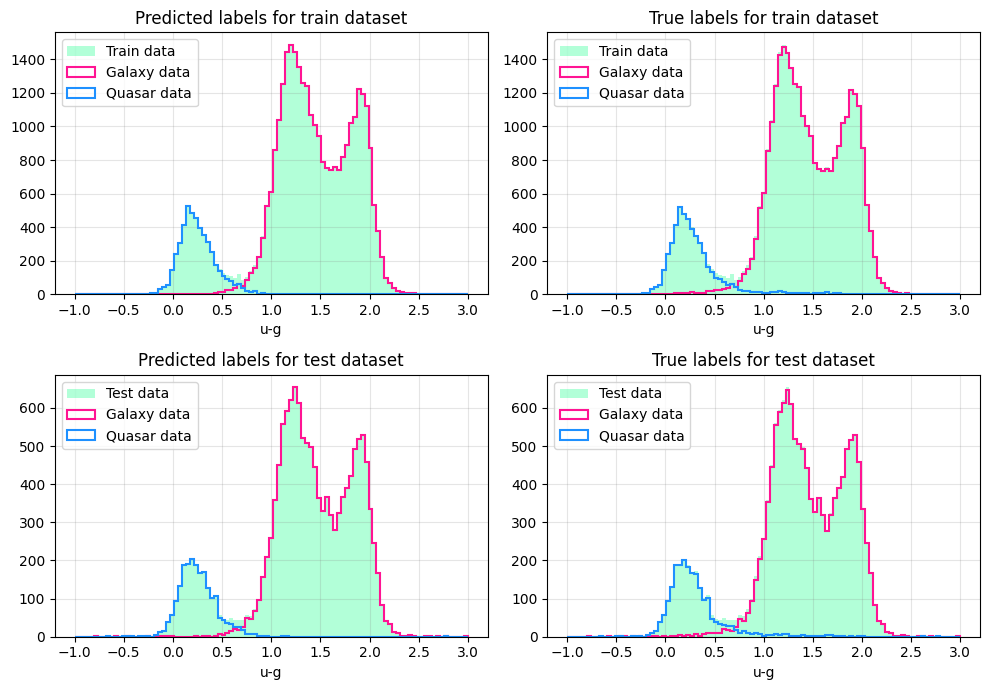

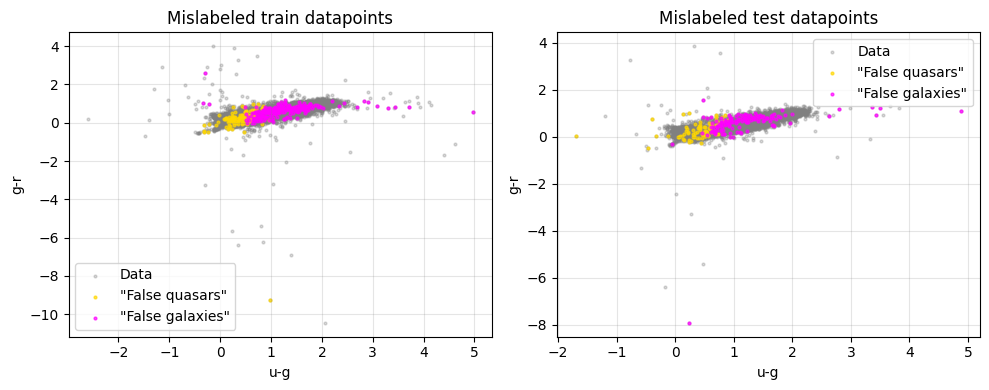

In [63]:
plot_classified_hists(X_train, X_test, y_train, y_test, y_train_pred_rf_best, y_test_pred_rf_best, 'u-g')

mislabeled_points(X_train, X_test, y_train, y_test, y_train_pred_rf_best, y_test_pred_rf_best, 'u-g', 'g-r')


## Boosting

This time, we can check the performance for:

- Different features;
- Different number of features;
- Different learning rates;
- Different max_depth for the trees.

As always, let's fisrt check the ROC curves for these first two parameters (keeping the default value for learning_rate = 0.1 and fixing max_depth = 10).

Training the data with a single feature:



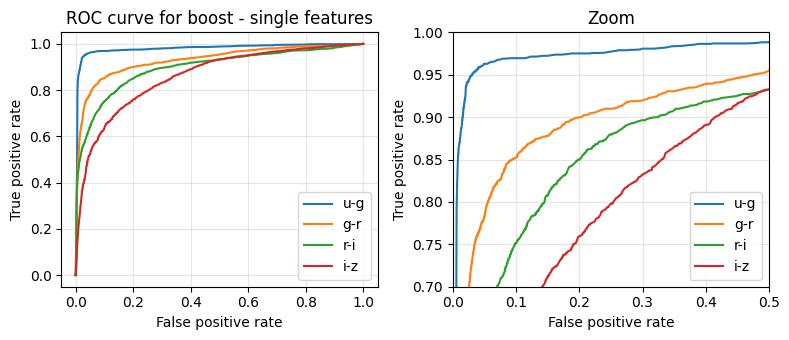

In [83]:
single_ROC(X_train, X_test, y_train, y_test, 'boost', 10)

Training the data with multiple features:



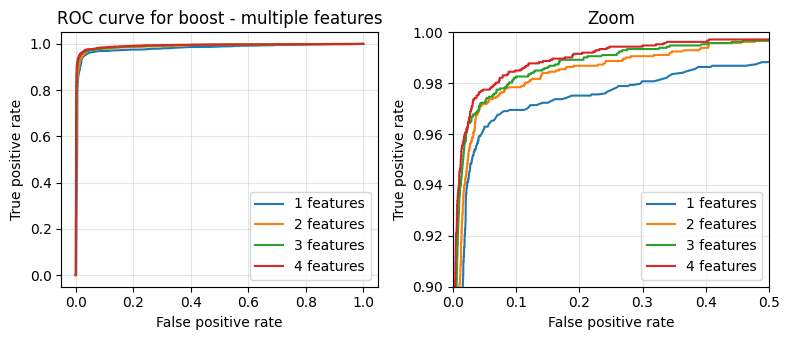

In [84]:
progressive_ROC(X_train, X_test, y_train, y_test, 'boost', 10)

Al always, the $(u-g)$ feature is the most informative one. Also, by these plots, it seems that training the classifier on 4 features yields the best results.

Let's see how the ROC curves behave for different learning rates (using max_depth = 10 and 4 features):

Training the data with different learning rates (and all features):



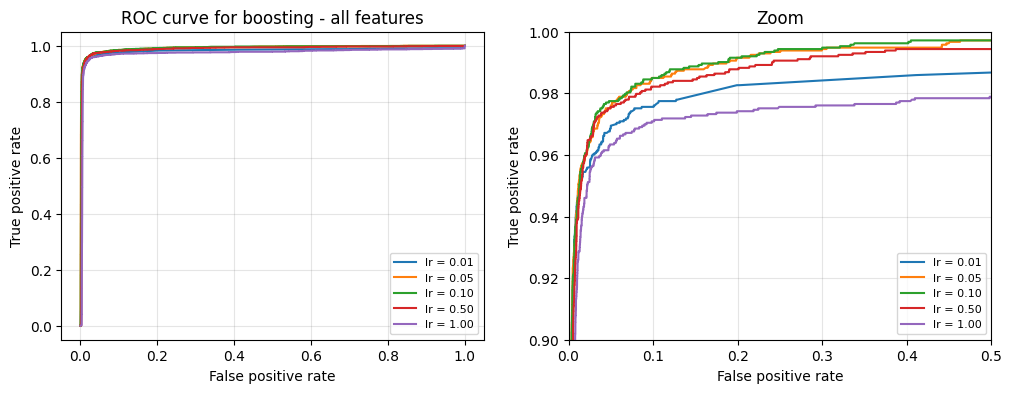

In [86]:
lr_range = [0.01, 0.05, 0.1, 0.5, 1]

print('Training the data with different learning rates (and all features):\n')

fig, ax = plt.subplots(1, 2, figsize = (12, 4))

for i, lr in enumerate(lr_range):
    
    boost = GradientBoostingClassifier(learning_rate = lr, max_depth = 10, random_state = 336)
    boost.fit(X_train, y_train)
    y_prob = boost.predict_proba(X_test)[:, 1] 

    fpr, tpr, thresh = roc_curve(y_test, y_prob)
    ax[0].plot(fpr, tpr, label='lr = %.2f' % lr)
    ax[1].plot(fpr, tpr, label='lr = %.2f' % lr)

ax[0].set_xlabel('False positive rate')
ax[0].set_ylabel('True positive rate')
ax[0].set_title('ROC curve for boosting - all features')
ax[0].legend(loc='lower right', fontsize = 8)
ax[0].grid(c='grey', alpha = 0.2)

ax[1].set_xlabel('False positive rate')
ax[1].set_ylabel('True positive rate')
ax[1].set_title('Zoom')
ax[1].legend(loc='lower right', fontsize = 8)
ax[1].grid(c='grey', alpha = 0.2)
ax[1].set_ylim(0.9, 1)
ax[1].set_xlim(0, 0.5)

plt.show()

So, it seems that the right range is between $0.05$ and $0.5$. 

And lastly, let's check the ROC curves for the max_depth:

Training the data with different maximum depths for the trees (and all features):



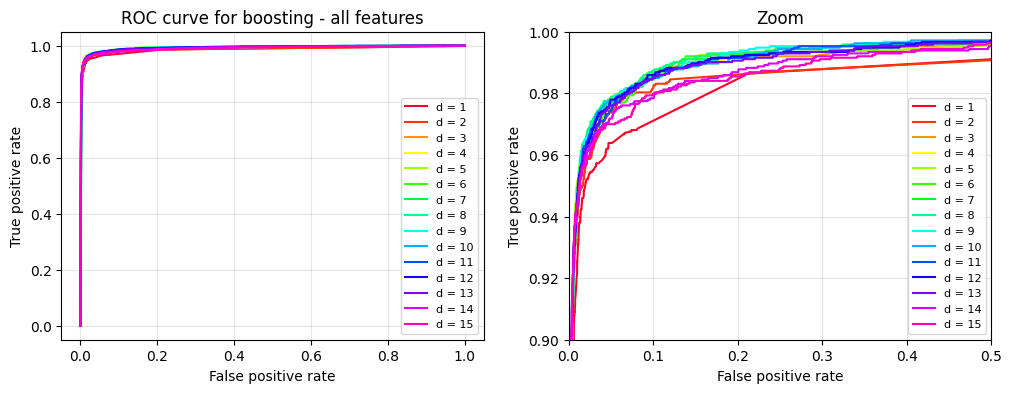

In [87]:
depth_range = np.arange(1, 16, dtype = int)

print('Training the data with different maximum depths for the trees (and all features):\n')

fig, ax = plt.subplots(1, 2, figsize = (12, 4))

plot_colors = plt.cm.gist_rainbow(np.linspace(0, 1, len(depth_range)))

for i, depth in enumerate(depth_range):

    boost = GradientBoostingClassifier(max_depth = depth, random_state = 336)
    boost.fit(X_train, y_train)
    y_prob = boost.predict_proba(X_test)[:, 1] 

    fpr, tpr, thresh = roc_curve(y_test, y_prob)
    ax[0].plot(fpr, tpr, label='d = %i' % depth, color = plot_colors[i])
    ax[1].plot(fpr, tpr, label='d = %i' % depth, color = plot_colors[i])

ax[0].set_xlabel('False positive rate')
ax[0].set_ylabel('True positive rate')
ax[0].set_title('ROC curve for boosting - all features')
ax[0].legend(loc='lower right', fontsize = 8)
ax[0].grid(c='grey', alpha = 0.2)

ax[1].set_xlabel('False positive rate')
ax[1].set_ylabel('True positive rate')
ax[1].set_title('Zoom')
ax[1].legend(loc='lower right', fontsize = 8)
ax[1].grid(c='grey', alpha = 0.2)
ax[1].set_ylim(0.9, 1)
ax[1].set_xlim(0, 0.5)

plt.show()

Here, the best results seem to be achieved for max_depth between $5$ and $12$.

We'll cross-validate now. To reduce the computational cost, we'll set the learning rate at its default value (that seemed to yield the best results anyway in its ROC curve).

In [88]:
n_splits = 10

depths_range = np.arange(3, 13, dtype = int)

auc_roc_cv_matrix = np.empty((len(depths_range), 4))
accuracy_cv_matrix = np.empty((len(depths_range), 4))
precision_cv_matrix = np.empty((len(depths_range), 4))
completeness_cv_matrix = np.empty((len(depths_range), 4))

kf = KFold(n_splits=n_splits, shuffle=True, random_state=336)

for i, depth in tqdm(enumerate(depths_range), total = len(depths_range)):     # Cycling on the components -> i
  
    boost = GradientBoostingClassifier(max_depth = depth, random_state = 336)

    for j in range(4):     # Cycling on the number of features -> j

        accuracy = []
        precision = []
        completeness = []
        auc_roc = []
        
        for train_index, test_index in kf.split(X_train):
            X_train_cv, X_test_cv = X_train[train_index], X_train[test_index]
            y_train_cv, y_test_cv = y_train[train_index], y_train[test_index]
            
            boost.fit(X_train_cv[:, 0:j+1], y_train_cv)
            y_pred_test_cv = boost.predict(X_test_cv[:, 0:j+1])
            y_prob_test_cv = boost.predict_proba(X_test_cv[:, 0:j+1])[:, 1] 
            
            accuracy.append(accuracy_score(y_test_cv, y_pred_test_cv))
            precision.append(precision_score(y_test_cv, y_pred_test_cv))
            completeness.append(recall_score(y_test_cv, y_pred_test_cv))
    
            fpr, tpr, _ = roc_curve(y_test_cv, y_prob_test_cv)
            auc_roc.append(auc(fpr, tpr))

        accuracy_cv_matrix[i, j] = np.mean(accuracy)
        precision_cv_matrix[i, j] = np.mean(precision)
        completeness_cv_matrix[i, j] = np.mean(completeness)
        auc_roc_cv_matrix[i, j] = np.mean(auc_roc)

  0%|          | 0/10 [00:00<?, ?it/s]

In [89]:
accuracy_cv_matrix

array([[0.98      , 0.98162857, 0.98374286, 0.98468571],
       [0.97822857, 0.98128571, 0.98311429, 0.98474286],
       [0.97745714, 0.98025714, 0.9828    , 0.98425714],
       [0.97648571, 0.97914286, 0.98174286, 0.98342857],
       [0.9746    , 0.97802857, 0.981     , 0.98337143],
       [0.97265714, 0.97808571, 0.9812    , 0.98308571],
       [0.97291429, 0.97674286, 0.98114286, 0.98385714],
       [0.972     , 0.977     , 0.9808    , 0.98362857],
       [0.97145714, 0.97705714, 0.9818    , 0.984     ],
       [0.97068571, 0.97685714, 0.98177143, 0.9838    ]])

In [90]:
precision_cv_matrix

array([[0.93215153, 0.94221353, 0.95145171, 0.95474943],
       [0.92630965, 0.93922797, 0.94827264, 0.95551847],
       [0.92442533, 0.93362829, 0.94690674, 0.95196566],
       [0.92112647, 0.9307246 , 0.94244474, 0.947024  ],
       [0.91092375, 0.92486581, 0.93947322, 0.94662095],
       [0.90248805, 0.92706234, 0.93946039, 0.94501191],
       [0.90428923, 0.92005367, 0.93778566, 0.9483854 ],
       [0.90317742, 0.92197111, 0.93635431, 0.94888127],
       [0.90283562, 0.9231898 , 0.9414812 , 0.95236178],
       [0.89953045, 0.92347624, 0.94240905, 0.95284433]])

In [91]:
completeness_cv_matrix

array([[0.9273973 , 0.9280487 , 0.9336431 , 0.93697501],
       [0.92087829, 0.9287713 , 0.93248678, 0.93654879],
       [0.91699284, 0.92745614, 0.93163545, 0.9366887 ],
       [0.91321256, 0.92252391, 0.92865523, 0.93625851],
       [0.91101237, 0.92083373, 0.92641688, 0.93618528],
       [0.9062057 , 0.91877045, 0.92798183, 0.93594807],
       [0.90580699, 0.91684175, 0.9294214 , 0.93775587],
       [0.90011959, 0.91638339, 0.92859997, 0.93551869],
       [0.89624269, 0.91544661, 0.92996582, 0.93451823],
       [0.89418318, 0.9134294 , 0.92875673, 0.93259045]])

In [93]:
auc_roc_cv_matrix

array([[0.98316124, 0.98734941, 0.98908063, 0.99133584],
       [0.98182667, 0.98765723, 0.98965742, 0.99149173],
       [0.98109562, 0.98684651, 0.9898553 , 0.99192404],
       [0.97978861, 0.98763514, 0.98920586, 0.99040473],
       [0.97932881, 0.98643949, 0.98939211, 0.99151627],
       [0.97893131, 0.98657737, 0.98939579, 0.99120778],
       [0.97900718, 0.98714723, 0.9891768 , 0.99163336],
       [0.97996547, 0.98677505, 0.98928841, 0.99233711],
       [0.97853174, 0.98664865, 0.98971811, 0.99229033],
       [0.9788809 , 0.98641857, 0.98966392, 0.99238177]])

In [94]:
print('Depths considered:')
print(depths_range)

best_index_flat = np.argmax(accuracy_cv_matrix) 
best_index_2d = np.unravel_index(best_index_flat, accuracy_cv_matrix.shape)

best_depth_acc = depths_range[best_index_2d[0]]
best_n_features_acc = best_index_2d[1]+1

print('\nBest maximum depth: %i' % best_depth_acc) 
print('Best numbers of features to train the classifier on: %i' % best_n_features_acc)

Depths considered:
[ 3  4  5  6  7  8  9 10 11 12]

Best maximum depth: 4
Best numbers of features to train the classifier on: 4


Since the range of depths considered is bigger, let's see what the other scores say:

In [101]:
best_index_flat = np.argmax(completeness_cv_matrix) 
best_index_2d = np.unravel_index(best_index_flat, completeness_cv_matrix.shape)

best_depth_compl = depths_range[best_index_2d[0]]
best_n_features_compl = best_index_2d[1]+1

print('Completeness')
print('Best maximum depth: %i' % best_depth_compl) 
print('Best numbers of features to train the classifier on: %i' % best_n_features_compl)

#--------------------------------------------------------------------------------------------

best_index_flat = np.argmax(precision_cv_matrix) 
best_index_2d = np.unravel_index(best_index_flat, precision_cv_matrix.shape)

best_depth_cont = depths_range[best_index_2d[0]]
best_n_features_cont = best_index_2d[1]+1

print('\nContamination')
print('Best maximum depth: %i' % best_depth_cont) 
print('Best numbers of features to train the classifier on: %i' % best_n_features_cont)

#--------------------------------------------------------------------------------------------

best_index_flat = np.argmax(auc_roc_cv_matrix) 
best_index_2d = np.unravel_index(best_index_flat, auc_roc_cv_matrix.shape)

best_depth_auc = depths_range[best_index_2d[0]]
best_n_features_auc = best_index_2d[1]+1

print('\nAUC-ROC')
print('Best maximum depth: %i' % best_depth_auc) 
print('Best numbers of features to train the classifier on: %i' % best_n_features_auc)

Completeness
Best maximum depth: 9
Best numbers of features to train the classifier on: 4

Contamination
Best maximum depth: 4
Best numbers of features to train the classifier on: 4

AUC-ROC
Best maximum depth: 12
Best numbers of features to train the classifier on: 4


As done for the K-nearest neighbors, let's see the results for these classifications.

In [102]:
boo_results_train = []
boo_results_test = []

scoring_metrics = ['Accuracy', 'AUC-ROC', 'Contamination', 'Completeness']

best_depth = [best_depth_acc, best_depth_auc, best_depth_cont, best_depth_compl]

for depth in best_depth:

    boost = GradientBoostingClassifier(max_depth = depth, random_state = 336)
    boost.fit(X_train, y_train)
    
    y_train_pred_boo = boost.predict(X_train)
    y_test_pred_boo = boost.predict(X_test)
    
    boo_results_train.append(table_results(y_train, y_train_pred_boo))
    boo_results_test.append(table_results(y_test, y_test_pred_boo))

In [103]:
clf_names = ['Boosting', 'Boosting', 'Boosting', 'Boosting']
clf_notes = ['Depth = 4', 'Depth = 12', 'Depth = 4', 'Depth = 9']

boo_results_train_df = pd.DataFrame(boo_results_train, columns = ['Accuracy', 'Contamination', 'Completeness', 'True negatives', 'False positives', 'False negatives', 'True positives'])
boo_results_train_df[['Accuracy', 'Contamination', 'Completeness']] = boo_results_train_df[['Accuracy', 'Contamination', 'Completeness']].round(3)
boo_results_train_df.insert(0, 'Classifier', clf_names)
boo_results_train_df.insert(1, 'Scoring metric', scoring_metrics)
boo_results_train_df.insert(2, 'Notes', clf_notes)

boo_results_test_df = pd.DataFrame(boo_results_test, columns = ['Accuracy', 'Contamination', 'Completeness', 'True negatives', 'False positives', 'False negatives', 'True positives'])
boo_results_test_df[['Accuracy', 'Contamination', 'Completeness']] = boo_results_test_df[['Accuracy', 'Contamination', 'Completeness']].round(3)
boo_results_test_df.insert(0, 'Classifier', clf_names)
boo_results_test_df.insert(1, 'Scoring metric', scoring_metrics)
boo_results_test_df.insert(2, 'Notes', clf_notes)

In [104]:
display(Markdown('### Boosting - Train results:'))
display(boo_results_train_df)

display(Markdown('### Boosting - Test results:'))
display(boo_results_test_df)

### Boosting - Train results:

,Classifier,Scoring metric,Notes,Accuracy,Contamination,Completeness,True negatives,False positives,False negatives,True positives
0,Boosting,Accuracy,Depth = 4,0.990,0.024,0.954,29880,117,229,4774
1,Boosting,AUC-ROC,Depth = 12,1.000,0.000,1.000,29997,0,0,5003
2,Boosting,Contamination,Depth = 4,0.990,0.024,0.954,29880,117,229,4774
3,Boosting,Completeness,Depth = 9,0.999,0.000,0.996,29996,1,20,4983


### Boosting - Test results:

,Classifier,Scoring metric,Notes,Accuracy,Contamination,Completeness,True negatives,False positives,False negatives,True positives
0,Boosting,Accuracy,Depth = 4,0.985,0.043,0.935,12780,89,139,1992
1,Boosting,AUC-ROC,Depth = 12,0.984,0.046,0.933,12774,95,142,1989
2,Boosting,Contamination,Depth = 4,0.985,0.043,0.935,12780,89,139,1992
3,Boosting,Completeness,Depth = 9,0.984,0.047,0.936,12771,98,136,1995


This shows that depth = $9$ and $12$ is too much and leads to overfitting. Depth = $4$, instead, still yields good results. We'll consider that value.

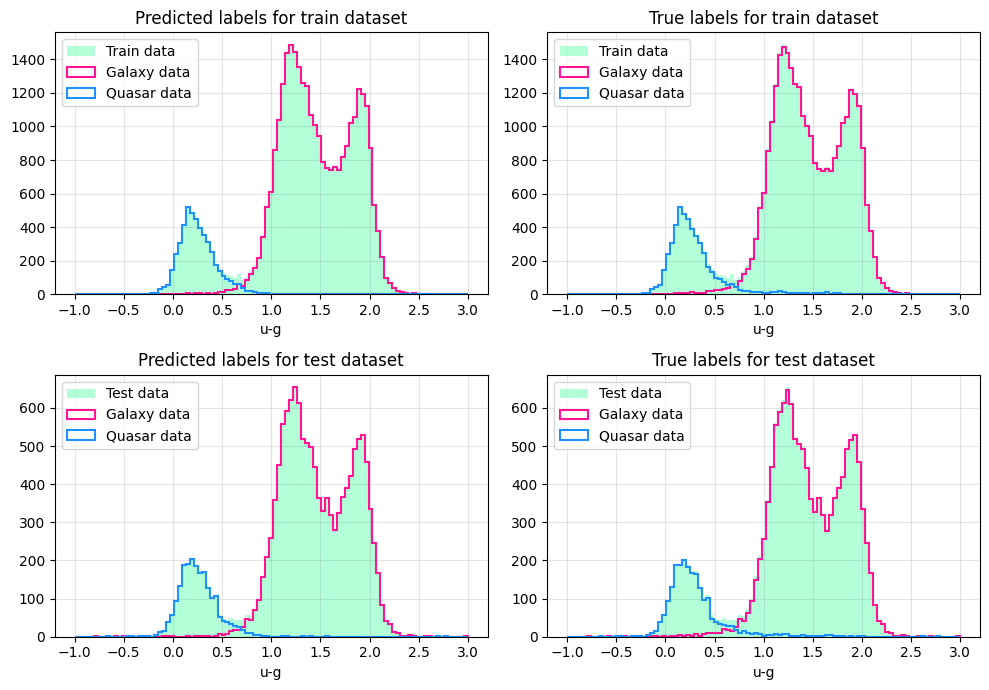

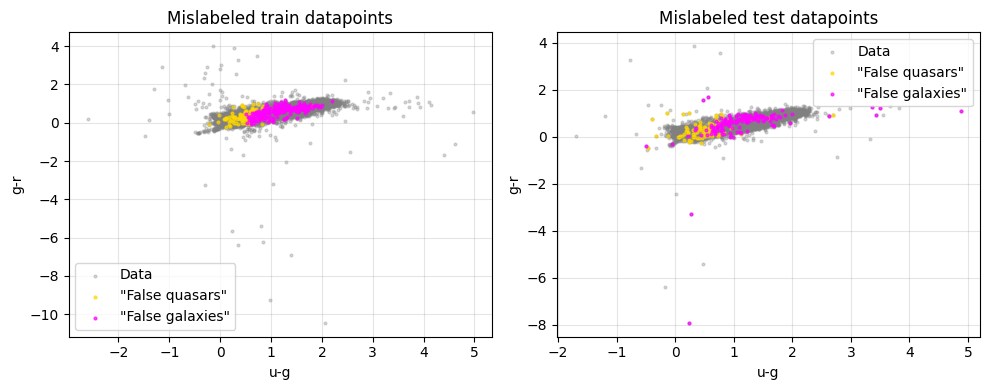

In [106]:
boost = GradientBoostingClassifier(max_depth = best_depth_acc, random_state = 336)
boost.fit(X_train, y_train)

y_train_pred_boo_best = boost.predict(X_train)
y_test_pred_boo_best = boost.predict(X_test)

plot_classified_hists(X_train, X_test, y_train, y_test, y_train_pred_boo_best, y_test_pred_boo_best, 'u-g')

mislabeled_points(X_train, X_test, y_train, y_test, y_train_pred_boo_best, y_test_pred_boo_best, 'u-g', 'g-r')

In [107]:
# For the DataFrame in the summary:
# Dropping the scoring metric column
boo_results_train_df = boo_results_train_df.drop(columns=['Scoring metric'])
boo_results_test_df = boo_results_test_df.drop(columns=['Scoring metric'])

# Dropping all rows except for the one cross-validated on accuracy (so, index = 0):
boo_results_train_df = boo_results_train_df.drop(index = 3)
boo_results_train_df = boo_results_train_df.drop(index = 2)
boo_results_train_df = boo_results_train_df.drop(index = 1)

boo_results_test_df = boo_results_test_df.drop(index = 3)
boo_results_test_df = boo_results_test_df.drop(index = 2)
boo_results_test_df = boo_results_test_df.drop(index = 1)

Let's now recap the different results to choose the best classifier.

## Summary


In [108]:
summary_train_df = pd.concat([gnb_results_train_df, qda_results_train_df, gmmb_results_train_df, knn_results_train_df, rf_results_train_df, boo_results_train_df])
summary_test_df = pd.concat([gnb_results_test_df, qda_results_test_df, gmmb_results_test_df, knn_results_test_df, rf_results_test_df, boo_results_test_df])

In [109]:
display(Markdown('### Train'))
display(summary_train_df)

display(Markdown('### Test'))
display(summary_test_df)

### Train

,Classifier,Notes,Accuracy,Contamination,Completeness,True negatives,False positives,False negatives,True positives
0,GNB,(u-g),0.981,0.062,0.929,29688,309,353,4650
0,QDA,3 features,0.981,0.064,0.934,29679,318,332,4671
0,GMMB,18 components - all features,0.986,0.039,0.938,29804,193,309,4694
0,KNN,"6 NN, all features",0.988,0.026,0.940,29871,126,300,4703
0,RF,"Max_depth = 14, all features",0.990,0.024,0.951,29881,116,247,4756
0,Boosting,Depth = 4,0.990,0.024,0.954,29880,117,229,4774


### Test

,Classifier,Notes,Accuracy,Contamination,Completeness,True negatives,False positives,False negatives,True positives
0,GNB,(u-g),0.981,0.062,0.925,12738,131,160,1971
0,QDA,3 features,0.980,0.068,0.929,12725,144,152,1979
0,GMMB,18 components - all features,0.985,0.039,0.936,12787,82,136,1995
0,KNN,"6 NN, all features",0.985,0.035,0.931,12797,72,146,1985
0,RF,"Max_depth = 14, all features",0.986,0.037,0.936,12793,76,137,1994
0,Boosting,Depth = 4,0.985,0.043,0.935,12780,89,139,1992


The accuracies on the test dataset are very similar to each other! 


## Applying PCA

As a last try, we can apply a PCA to the data before classifying. We'll first display the scree plots. 

In [66]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from matplotlib.ticker import PercentFormatter

In the 1° eigenvalue is encapsulated 55.0% of the variance (cumulative variance: 55.0%)
In the 2° eigenvalue is encapsulated 29.7% of the variance (cumulative variance: 84.8%)
In the 3° eigenvalue is encapsulated 10.8% of the variance (cumulative variance: 95.6%)
In the 4° eigenvalue is encapsulated 4.4% of the variance (cumulative variance: 100.0%)



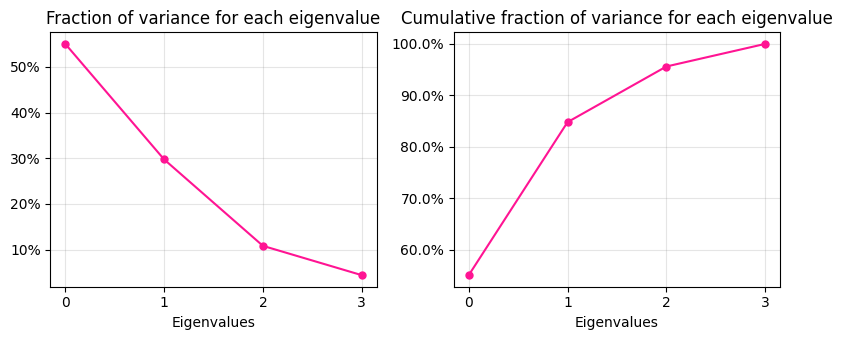

In [67]:
scaler = StandardScaler()
scaled_X_train = scaler.fit_transform(X_train)
scaled_X_test = scaler.transform(X_test)
# I'm fitting the scaler and the pca ONLY on X_train: this way, X_test will remain "unseen".

pca = PCA(n_components=4, random_state = 336)

X_train_pca = pca.fit_transform(scaled_X_train) 
X_test_pca = pca.transform(scaled_X_test)
evals = pca.explained_variance_ratio_ 

for i, v in enumerate(evals):
    print("In the %i° eigenvalue is encapsulated %.1f%% of the variance (cumulative variance: %.1f%%)" % (i+1, v*100, np.cumsum(evals)[i]*100))

print()

fig, ax = plt.subplots(1, 2, figsize=(8, 3.5))
xgrid = np.arange(4)

ax[0].plot(xgrid, evals, marker = 'o', markersize = 5, ls = '-', color = 'deeppink')
ax[0].grid(c='grey', alpha = 0.2)
ax[0].set_xlabel('Eigenvalues')
ax[0].set_xticks(xgrid)
ax[0].yaxis.set_major_formatter(PercentFormatter(xmax=1))
ax[0].set_title('Fraction of variance for each eigenvalue')

ax[1].plot(xgrid, np.cumsum(evals), marker = 'o', markersize = 5, ls = '-', color = 'deeppink')
ax[1].grid(c='grey', alpha = 0.2)
ax[1].set_xlabel('Eigenvalues')
ax[1].set_xticks(xgrid)
ax[1].yaxis.set_major_formatter(PercentFormatter(xmax=1))
ax[1].set_title('Cumulative fraction of variance for each eigenvalue')

plt.tight_layout()
plt.show()

_Note: since the first component only explains a little more than half of the variance, I'm afraid all the components will be needed._

As a classifier, we'll use the Random Forest. Let's plot the ROC curves, keeping for now the max_depth found before:

Training the data with a single feature:



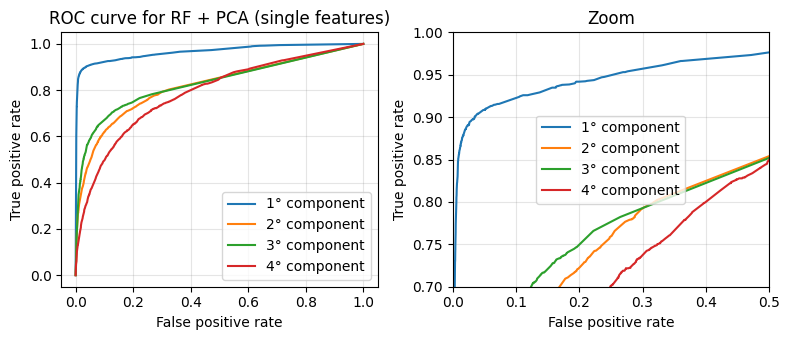

In [110]:
print('Training the data with a single feature:\n')

fig, ax = plt.subplots(1, 2, figsize = (8, 3.5))

rand_for = RandomForestClassifier(max_depth = best_depth_acc, min_samples_split = 20, criterion = 'entropy', random_state = 336, n_jobs = -1)

for i in range(4):

    pca = PCA(n_components=i+1, random_state = 336)
    
    X_train_pca = pca.fit_transform(scaled_X_train) 
    X_test_pca = pca.transform(scaled_X_test)
    
    rand_for.fit(X_train_pca[:, i].reshape(-1, 1), y_train)
    y_prob = rand_for.predict_proba(X_test_pca[:, i].reshape(-1, 1))[:, 1] 

    fpr, tpr, thresh = roc_curve(y_test, y_prob)
    ax[0].plot(fpr, tpr, label='%i° component' % (i+1))
    ax[1].plot(fpr, tpr, label='%i° component' % (i+1))

ax[0].set_xlabel('False positive rate')
ax[0].set_ylabel('True positive rate')
ax[0].set_title('ROC curve for RF + PCA (single features)')
ax[0].legend(loc='best')
ax[0].grid(c='grey', alpha = 0.2)

ax[1].set_xlabel('False positive rate')
ax[1].set_ylabel('True positive rate')
ax[1].set_title('Zoom')
ax[1].legend(loc='best')
ax[1].grid(c='grey', alpha = 0.2)
ax[1].set_ylim(0.7, 1)
ax[1].set_xlim(0, 0.5)

plt.tight_layout()
plt.show()


Training the data with multiple features:



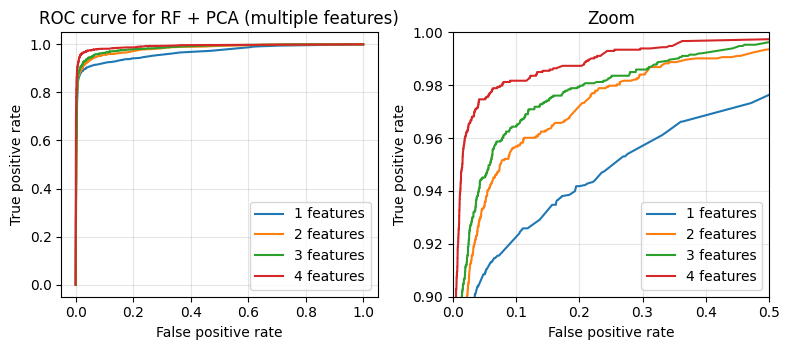

In [111]:
print('Training the data with multiple features:\n')

fig, ax = plt.subplots(1, 2, figsize = (8, 3.6))

rand_for = RandomForestClassifier(max_depth = best_depth_acc, min_samples_split = 20, criterion = 'entropy', random_state = 336, n_jobs = -1)

for i in range(4):

    pca = PCA(n_components=i+1, random_state = 336)
    
    X_train_pca = pca.fit_transform(scaled_X_train) 
    X_test_pca = pca.transform(scaled_X_test)
        
    rand_for.fit(X_train_pca[:, 0:i+1], y_train)
    y_prob = rand_for.predict_proba(X_test_pca[:, 0:i+1])[:, 1] 

    fpr, tpr, thresh = roc_curve(y_test, y_prob)
    ax[0].plot(fpr, tpr, label= '%i features' % (i+1))
    ax[1].plot(fpr, tpr, label= '%i features' % (i+1))

ax[0].set_xlabel('False positive rate')
ax[0].set_ylabel('True positive rate')
ax[0].set_title('ROC curve for RF + PCA (multiple features)')
ax[0].legend(loc='best')
ax[0].grid(c='grey', alpha = 0.2)

ax[1].set_xlabel('False positive rate')
ax[1].set_ylabel('True positive rate')
ax[1].set_title('Zoom')
ax[1].legend(loc='best')
ax[1].grid(c='grey', alpha = 0.2)
ax[1].set_ylim(0.9, 1)
ax[1].set_xlim(0, 0.5)

plt.tight_layout()
plt.show()

Indeed, the classifier performs better with all 4 components. Let's find the best max_depth:

In [112]:
n_splits = 10

pca = PCA(n_components=4, random_state = 336)

X_train_pca = pca.fit_transform(scaled_X_train) 
X_test_pca = pca.transform(scaled_X_test)

depths_range = np.arange(1, 16, dtype = int)

auc_roc_cv_array = np.empty((len(depths_range)))
accuracy_cv_array = np.empty((len(depths_range)))
precision_cv_array = np.empty((len(depths_range)))
completeness_cv_array = np.empty((len(depths_range)))

kf = KFold(n_splits=n_splits, shuffle=True, random_state=336)

for i, depth in tqdm(enumerate(depths_range), total = len(depths_range)):
  
    rand_for = RandomForestClassifier(max_depth = depth, min_samples_split = 20, criterion = 'entropy', random_state = 336, n_jobs = -1)

    accuracy = []
    precision = []
    completeness = []
    auc_roc = []
    
    for train_index, test_index in kf.split(X_train_pca):
        X_train_cv, X_test_cv = X_train_pca[train_index], X_train_pca[test_index]
        y_train_cv, y_test_cv = y_train[train_index], y_train[test_index]
        
        rand_for.fit(X_train_cv, y_train_cv)
        y_pred_test_cv = rand_for.predict(X_test_cv)
        y_prob_test_cv = rand_for.predict_proba(X_test_cv)[:, 1] 
        
        accuracy.append(accuracy_score(y_test_cv, y_pred_test_cv))
        precision.append(precision_score(y_test_cv, y_pred_test_cv))
        completeness.append(recall_score(y_test_cv, y_pred_test_cv))

        fpr, tpr, _ = roc_curve(y_test_cv, y_prob_test_cv)
        auc_roc.append(auc(fpr, tpr))

    accuracy_cv_array[i] = np.mean(accuracy)
    precision_cv_array[i] = np.mean(precision)
    completeness_cv_array[i] = np.mean(completeness)
    auc_roc_cv_array[i] = np.mean(auc_roc)

  0%|          | 0/15 [00:00<?, ?it/s]

In [113]:
accuracy_cv_array

array([0.93474286, 0.97174286, 0.97734286, 0.982     , 0.98414286,
       0.9848    , 0.98554286, 0.98551429, 0.98577143, 0.9858    ,
       0.98582857, 0.98582857, 0.98568571, 0.98588571, 0.98577143])

In [114]:
precision_cv_array

array([0.94008397, 0.92441575, 0.93159208, 0.94581516, 0.95453934,
       0.95642631, 0.95951127, 0.95898739, 0.96078764, 0.96097618,
       0.96138999, 0.96098813, 0.96076883, 0.96160353, 0.96094209])

In [115]:
completeness_cv_array

array([0.58240201, 0.87334246, 0.90767693, 0.92662365, 0.93296254,
       0.93573436, 0.93798633, 0.9383845 , 0.93841821, 0.93841043,
       0.93824807, 0.93863463, 0.93783053, 0.93844203, 0.9382612 ])

In [116]:
auc_roc_cv_array

array([0.9641983 , 0.98645757, 0.98902458, 0.99025106, 0.9912587 ,
       0.99212244, 0.99266792, 0.9931493 , 0.99347462, 0.99342771,
       0.99357938, 0.99348092, 0.99328376, 0.99331492, 0.99353834])

In [117]:
print('Depths considered:')
print(depths_range)

best_index = np.argmax(accuracy_cv_array) 
best_depth = depths_range[best_index]

print('\nBest maximum depth: %i' % best_depth) 

Depths considered:
[ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15]

Best maximum depth: 14


It's the same result as before applying the pca.

Displaying the results:

In [118]:
pca_rf_results_train = []
pca_rf_results_test = []

rand_for = RandomForestClassifier(max_depth = best_depth, min_samples_split = 20, criterion = 'entropy', random_state = 336, n_jobs = -1)
rand_for.fit(X_train_pca, y_train)

y_train_pred_rf_pca = rand_for.predict(X_train_pca)
y_test_pred_rf_pca = rand_for.predict(X_test_pca)

pca_rf_results_train.append(table_results(y_train, y_train_pred_rf_pca))
pca_rf_results_test.append(table_results(y_test, y_test_pred_rf_pca))

In [119]:
clf_names = ['RF']
clf_notes = ['Max_depth = 14, all features']

rf_pca_results_train_df = pd.DataFrame(pca_rf_results_train, columns = ['Accuracy', 'Contamination', 'Completeness', 'True negatives', 'False positives', 'False negatives', 'True positives'])
rf_pca_results_train_df[['Accuracy', 'Contamination', 'Completeness']] = rf_pca_results_train_df[['Accuracy', 'Contamination', 'Completeness']].round(3)
rf_pca_results_train_df.insert(0, 'Classifier', clf_names)
rf_pca_results_train_df.insert(1, 'Notes', clf_notes)

rf_pca_results_test_df = pd.DataFrame(pca_rf_results_test, columns = ['Accuracy', 'Contamination', 'Completeness', 'True negatives', 'False positives', 'False negatives', 'True positives'])
rf_pca_results_test_df[['Accuracy', 'Contamination', 'Completeness']] = rf_pca_results_test_df[['Accuracy', 'Contamination', 'Completeness']].round(3)
rf_pca_results_test_df.insert(0, 'Classifier', clf_names)
rf_pca_results_test_df.insert(1, 'Notes', clf_notes)

In [120]:
display(Markdown('## Results before PCA'))

display(Markdown('#### Train'))
display(summary_train_df)

display(Markdown('#### Test'))
display(summary_test_df)

print()

display(Markdown('### Random forest with PCA - Train results:'))
display(rf_pca_results_train_df)

display(Markdown('### Random forest with PCA - Test results:'))
display(rf_pca_results_test_df)

## Results before PCA

#### Train

,Classifier,Notes,Accuracy,Contamination,Completeness,True negatives,False positives,False negatives,True positives
0,GNB,(u-g),0.981,0.062,0.929,29688,309,353,4650
0,QDA,3 features,0.981,0.064,0.934,29679,318,332,4671
0,GMMB,18 components - all features,0.986,0.039,0.938,29804,193,309,4694
0,KNN,"6 NN, all features",0.988,0.026,0.940,29871,126,300,4703
0,RF,"Max_depth = 14, all features",0.990,0.024,0.951,29881,116,247,4756
0,Boosting,Depth = 4,0.990,0.024,0.954,29880,117,229,4774


#### Test

,Classifier,Notes,Accuracy,Contamination,Completeness,True negatives,False positives,False negatives,True positives
0,GNB,(u-g),0.981,0.062,0.925,12738,131,160,1971
0,QDA,3 features,0.980,0.068,0.929,12725,144,152,1979
0,GMMB,18 components - all features,0.985,0.039,0.936,12787,82,136,1995
0,KNN,"6 NN, all features",0.985,0.035,0.931,12797,72,146,1985
0,RF,"Max_depth = 14, all features",0.986,0.037,0.936,12793,76,137,1994
0,Boosting,Depth = 4,0.985,0.043,0.935,12780,89,139,1992


### Random forest with PCA - Train results:

,Classifier,Notes,Accuracy,Contamination,Completeness,True negatives,False positives,False negatives,True positives
0,RF,"Max_depth = 14, all features",0.99,0.022,0.952,29889,108,241,4762


### Random forest with PCA - Test results:

,Classifier,Notes,Accuracy,Contamination,Completeness,True negatives,False positives,False negatives,True positives
0,RF,"Max_depth = 14, all features",0.985,0.039,0.934,12788,81,140,1991


So, dimensionality reduction didn't improve the classifier performance.